In [60]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['pdf.fonttype'] = 42
import statsmodels.formula.api as smf
import pingouin as pg

In [61]:
#import intake datasheet
master = pd.read_excel('Final/Ethanol Consumption Sheet Final.xlsx')
master

,File,SessionDuration,Experiment,Session,ID,Genotype,Sex,Fluid,Intake
0,06-06-24.csv,2h,1,1,WT1,WT,Female,Alcohol,4.060280
1,06-06-24.csv,2h,1,1,WT2,WT,Female,Alcohol,2.448513
2,06-06-24.csv,2h,1,1,WT3,WT,Female,Alcohol,0.952128
3,06-06-24.csv,2h,1,1,WT4,WT,Female,Alcohol,1.304698
4,06-06-24.csv,2h,1,1,ADH1,Adh1 KO,Female,Alcohol,0.160440
...,...,...,...,...,...,...,...,...,...
157,01282025.CSV,4h,6,2,WT17,WT,Female,Quinine,2.051282
158,01282025.CSV,4h,6,2,ADH16,Adh1 KO,Female,Quinine,53.090909
159,01282025.CSV,4h,6,2,ADH17,Adh1 KO,Female,Quinine,0.977199
160,01282025.CSV,4h,6,2,ADH18,Adh1 KO,Female,Quinine,22.318841


In [4]:
# Initialize master_drinker as an empty DataFrame
sacharrin = pd.DataFrame()

# Folder where CSV files are stored
folder_path = 'For Analysis'

# Function to construct file path
def get_file_path(date, folder_path):
    return os.path.join(folder_path, f"{date}")

# List to store DataFrames
dataframes = []

#files to search
datelist = master.loc[master['Experiment'] == 1,'File'].unique()

# Loop through dates and load corresponding CSV files
for i in datelist:
    file_path = get_file_path(i, folder_path)
    
    # Check if the file exists
    if os.path.exists(file_path):
        # Load the CSV file into a DataFrame and append to the list
        df = pd.read_csv(file_path)
        #assign date and time columns to datimetime elements
        df['MM:DD:YY'] = pd.to_datetime(df['MM:DD:YY'])
        df['MillisSinceMidnight'] = pd.to_timedelta(df['MillisSinceMidnight'], unit='ms')

        #add them together to get the correctly formated datetime string with .100 millisecond precision
        df['DrinkStop'] = df['MM:DD:YY'] + df['MillisSinceMidnight']
        #drop the old columns that we dont need
        df.drop(columns=['MM:DD:YY','MillisSinceMidnight'], inplace=True)

        #resort the index
        df.set_index('DrinkStop', inplace=True)
        df.sort_index(inplace=True)
        df.reset_index(inplace=True)
        
        print(f"Loaded {file_path}")
    else:
        print(f"File {file_path} does not exist.")
    for j in master.loc[master['File'] == i, 'ID'].unique():
        print(j)
        current_animal = df.loc[:, df.columns.str.contains(j) | df.columns.isin(['DrinkStop'])].copy()
        current_animal['ID'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'ID'].iloc[0]
        current_animal['Session'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'Session'].iloc[0]
        current_animal['Duration'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'SessionDuration'].iloc[0]
        current_animal['Experiment'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'Experiment'].iloc[0]
        current_animal['Genotype'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'Genotype'].iloc[0]
        current_animal['Sex'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'Sex'].iloc[0]
        current_animal['Fluid'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'Fluid'].iloc[0]
        current_animal['Intake'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'Intake'].iloc[0]
        
        # Create a dictionary for renaming columns containing '_Count' and '_Duration'
        rename_dict = {
            col: 'Total_Licks' if '_Count' in col else 'Lick_Duration' if '_Duration' in col else col
            for col in current_animal.columns
        }
        # Rename the columns
        current_animal.rename(columns=rename_dict, inplace=True)

        #calculate licks in binary
        current_animal['Lick'] = current_animal['Total_Licks'].diff()

        #filter out data from other animals
        current_animal = current_animal.loc[current_animal['Lick'] != 0]

        #fix the errors from sorting the index
        current_animal['Lick'] = 1
        current_animal.loc[0,'Lick'] = np.nan

        #compute drink start time 
        current_animal['DrinkStart'] = current_animal['DrinkStop'] - pd.to_timedelta(current_animal['Lick_Duration'], unit='ms')

        #calculate the elapsed time
        current_animal['ElapsedTime'] = current_animal['DrinkStop'] - current_animal['DrinkStop'].iloc[0]

        #calculate inter lick interval
        current_animal['ILI'] = current_animal['DrinkStart'] - current_animal['DrinkStop'].shift()

        #filter some errors
        current_animal = current_animal.loc[current_animal['ILI'].dt.days > -1]

        #bout start counter
        current_animal.set_index('DrinkStart', inplace=True)
        current_animal['BoutStartCounter'] = current_animal['Lick'].rolling(window='1s').count()
        current_animal.reset_index(inplace=True)

        # Define conditions
        def boutstart_condition(row):
            return row['BoutStartCounter'] >= 3

        def boutstop_condition(row):
            return row['ILI'] >= pd.Timedelta('3 second')

        # Initialize variables
        start_index = None
        stop_index = None
        filtered_segments = []
        last_stop_index = None
        bout_counter = 1

        # Iterate through rows
        for index, row in current_animal.iterrows():
            if start_index is None:
                if boutstart_condition(row) or (last_stop_index is not None and index == last_stop_index + 1):
                    start_index = index
            elif boutstop_condition(row):
                stop_index = index - 1  # Set stop_index to the previous row
                
                # Create the filtered segment
                if stop_index >= start_index:
                    if len(current_animal.loc[start_index:stop_index]) >= 3:
                        current_animal.loc[start_index:stop_index, "BoutNumber"] = bout_counter
                        bout_counter = bout_counter+1
                
                # Update last_stop_index and reset for next segment
                last_stop_index = stop_index
                start_index = None
                stop_index = None

        # Handle the last segment if it doesn't end with a boutstop
        if start_index is not None:
            if len(current_animal.loc[start_index:stop_index]) >= 3:
                    current_animal.loc[start_index:stop_index, "BoutNumber"] = bout_counter
                    bout_counter = bout_counter+1

        #need to add a step for zero drinking mice to add bout_counter
        if current_animal.loc[0,'Intake'] == 0:
            print('sober mouse')
            current_animal['BoutNumber'] = np.nan

        #lets clean up some things visually...
        current_animal = current_animal[['ID','Fluid','Sex','Genotype','Duration','Session','Experiment','Intake','DrinkStart','DrinkStop','ElapsedTime','Total_Licks','Lick','Lick_Duration','ILI',"BoutNumber"]]

        if len(current_animal.loc[current_animal['BoutNumber'].notnull()]) > 0:
            for k in current_animal.loc[current_animal['BoutNumber'].notnull(), 'BoutNumber'].unique():
                current_animal.loc[current_animal['BoutNumber'] == k, 'LicksinBout'] = current_animal.loc[current_animal['BoutNumber'] == k, 'Lick'].sum()
                current_animal.loc[current_animal['BoutNumber'] == k, 'LickDurationinBout'] = current_animal.loc[current_animal['BoutNumber'] == k, 'Lick_Duration'].sum() 
        
        # Append the current_animal DataFrame to master_drinker
        masterdrinker = pd.concat([sacharrin, current_animal], ignore_index=True)

    # Convert ElapsedTime to minutes for some ease in graphs
    masterdrinker['ElapsedTimeMinutes'] = masterdrinker['ElapsedTime'].dt.total_seconds()/60

masterdrinker.head()

Loaded For Analysis/06-06-24.csv
WT1
WT2
WT3
WT4
ADH1
ADH2
ADH3
ADH4
Loaded For Analysis/06-07-24.csv
WT1
WT2
WT3
WT4
ADH1
ADH2
ADH3
ADH4


,ID,Fluid,Sex,Genotype,Duration,Session,Experiment,Intake,DrinkStart,DrinkStop,ElapsedTime,Total_Licks,Lick,Lick_Duration,ILI,BoutNumber,LicksinBout,LickDurationinBout,ElapsedTimeMinutes
0,ADH4,Alcohol,Female,Adh1 KO,4h,2,1,1.672523,2024-06-07 09:49:55.195,2024-06-07 09:49:55.267,0 days 00:00:34.638000,1,1.0,72,0 days 00:00:34.566000,NaN,NaN,NaN,0.577300
1,ADH4,Alcohol,Female,Adh1 KO,4h,2,1,1.672523,2024-06-07 09:49:56.105,2024-06-07 09:49:56.117,0 days 00:00:35.488000,2,1.0,12,0 days 00:00:00.838000,NaN,NaN,NaN,0.591467
2,ADH4,Alcohol,Female,Adh1 KO,4h,2,1,1.672523,2024-06-07 09:55:35.572,2024-06-07 09:55:35.590,0 days 00:06:14.961000,3,1.0,18,0 days 00:05:39.455000,NaN,NaN,NaN,6.249350
3,ADH4,Alcohol,Female,Adh1 KO,4h,2,1,1.672523,2024-06-07 09:55:36.807,2024-06-07 09:55:36.837,0 days 00:06:16.208000,4,1.0,30,0 days 00:00:01.217000,NaN,NaN,NaN,6.270133
4,ADH4,Alcohol,Female,Adh1 KO,4h,2,1,1.672523,2024-06-07 09:55:37.230,2024-06-07 09:55:37.279,0 days 00:06:16.650000,5,1.0,49,0 days 00:00:00.393000,NaN,NaN,NaN,6.277500


In [5]:
# Initialize master_drinker as an empty DataFrame
cohort2 = pd.DataFrame()

# Folder where CSV files are stored
folder_path = 'For Analysis'

# Function to construct file path
def get_file_path(date, folder_path):
    return os.path.join(folder_path, f"{date}")

# List to store DataFrames
dataframes = []

#files to search
datelist = master.loc[master['Experiment'] == 2,'File'].unique()

# Loop through dates and load corresponding CSV files
for i in datelist:
    file_path = get_file_path(i, folder_path)
    
    # Check if the file exists
    if os.path.exists(file_path):
        # Load the CSV file into a DataFrame and append to the list
        df = pd.read_csv(file_path)
        df['MM:DD:YY'] = pd.to_datetime(df['MM:DD:YY'])
        print(i)
        
        for j in master.loc[master['File'] == i, 'ID'].unique():
            print(j)
            current_animal = df.loc[:, df.columns.str.contains(j) | df.columns.isin(['MM:DD:YY'])].copy()
            current_animal['ID'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'ID'].iloc[0]
            current_animal['Session'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'Session'].iloc[0]
            current_animal['Duration'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'SessionDuration'].iloc[0]
            current_animal['Experiment'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'Experiment'].iloc[0]
            current_animal['Genotype'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'Genotype'].iloc[0]
            current_animal['Sex'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'Sex'].iloc[0]
            current_animal['Fluid'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'Fluid'].iloc[0]
            current_animal['Intake'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'Intake'].iloc[0]
                        
            # Create a dictionary for renaming columns containing '_Count' and '_Duration'
            rename_dict = {
                col: 'Total_Licks' if '_Count' in col else 'DrinkStart' if '_Start' in col else 'DrinkStop' if '_Stop' in col else col
                for col in current_animal.columns
            }
            # Rename the columns
            current_animal.rename(columns=rename_dict, inplace=True)
            
            #calulate the elpased time from the DrinkStop to match other data from first cohort
            current_animal['ElapsedTime'] = pd.to_timedelta(current_animal['DrinkStop'], unit='ms')
            
            #define lick duration from stop minus start
            current_animal['Lick_Duration'] = current_animal['DrinkStop'] - current_animal['DrinkStart']
            
            #these data had no running HH:MM:SS.000 timer, so rewrite the start and stop shifted from the actual start time of the exepriment
            current_animal['DrinkStart'] = pd.to_timedelta(current_animal['DrinkStart'], unit='ms') + pd.to_timedelta('10:30:00') + current_animal['MM:DD:YY']
            current_animal['DrinkStop'] = pd.to_timedelta(current_animal['DrinkStop'], unit='ms') + pd.to_timedelta('10:30:00') + current_animal['MM:DD:YY']
            
            #resort the index
            current_animal.set_index('DrinkStop', inplace=True)
            current_animal.sort_index(inplace=True)
            current_animal.reset_index(inplace=True)
            
            #calculate licks in binary
            current_animal['Lick'] = current_animal['Total_Licks'].diff()
            
            #filter out data from other animals
            current_animal = current_animal.loc[current_animal['Lick'] != 0]
            
            #calculate inter lick interval
            current_animal['ILI'] = current_animal['DrinkStart'] - current_animal['DrinkStop'].shift()
            
            #bout start counter
            current_animal.set_index('DrinkStart', inplace=True)
            current_animal['BoutStartCounter'] = current_animal['Lick'].rolling(window='1s').count()
            current_animal.reset_index(inplace=True)

            # Define conditions
            def boutstart_condition(row):
                return row['BoutStartCounter'] >= 3

            def boutstop_condition(row):
                return row['ILI'] >= pd.Timedelta('3 second')

            # Initialize variables
            start_index = None
            stop_index = None
            filtered_segments = []
            last_stop_index = None
            bout_counter = 1

            # Iterate through rows
            for index, row in current_animal.iterrows():
                if start_index is None:
                    if boutstart_condition(row) or (last_stop_index is not None and index == last_stop_index + 1):
                        start_index = index
                elif boutstop_condition(row):
                    stop_index = index - 1  # Set stop_index to the previous row
                    
                    # Create the filtered segment
                    if stop_index >= start_index:
                        if len(current_animal.loc[start_index:stop_index]) >= 3:
                            current_animal.loc[start_index:stop_index, "BoutNumber"] = bout_counter
                            bout_counter = bout_counter+1
                    
                    # Update last_stop_index and reset for next segment
                    last_stop_index = stop_index
                    start_index = None
                    stop_index = None

            # Handle the last segment if it doesn't end with a boutstop
            if start_index is not None:
                if len(current_animal.loc[start_index:stop_index]) >= 3:
                        current_animal.loc[start_index:stop_index, "BoutNumber"] = bout_counter
                        bout_counter = bout_counter+1
            
            #need to add a step for zero drinking mice to add bout_counter
            if current_animal.loc[0,'Intake'] == 0:
                print('sober mouse')
                current_animal['BoutNumber'] = np.nan
            
            #lets clean up some things visually...
            current_animal = current_animal[['ID','Fluid','Sex','Genotype','Duration','Session','Experiment','Intake','DrinkStart','DrinkStop','ElapsedTime','Total_Licks','Lick','Lick_Duration','ILI',"BoutNumber"]]

            if len(current_animal.loc[current_animal['BoutNumber'].notnull()]) > 0:
                for k in current_animal.loc[current_animal['BoutNumber'].notnull(), 'BoutNumber'].unique():
                    current_animal.loc[current_animal['BoutNumber'] == k, 'LicksinBout'] = current_animal.loc[current_animal['BoutNumber'] == k, 'Lick'].sum()
                    current_animal.loc[current_animal['BoutNumber'] == k, 'LickDurationinBout'] = current_animal.loc[current_animal['BoutNumber'] == k, 'Lick_Duration'].sum() 
        
            
            # Append the current_animal DataFrame to master_drinker
            cohort2 = pd.concat([cohort2, current_animal], ignore_index=True)

        # Convert ElapsedTime to minutes for some ease in graphs
        cohort2['ElapsedTimeMinutes'] = cohort2['ElapsedTime'].dt.total_seconds()/60
                
            
cohort2.head()

06-10-24.csv
WT5
sober mouse
WT6
WT7
WT8
ADH5
ADH6
ADH7
sober mouse
ADH8
06-11-24.csv
WT5
WT6
WT7
WT8
ADH5
sober mouse
ADH6
ADH7
sober mouse
ADH8


,ID,Fluid,Sex,Genotype,Duration,Session,Experiment,Intake,DrinkStart,DrinkStop,ElapsedTime,Total_Licks,Lick,Lick_Duration,ILI,BoutNumber,LicksinBout,LickDurationinBout,ElapsedTimeMinutes
0,WT5,Alcohol,Male,WT,2h,1,2,0.000000,2024-06-10 10:30:00.000,2024-06-10 10:30:00.000,0 days 00:00:00,0,NaN,0,NaT,NaN,NaN,NaN,0.000000
1,WT6,Alcohol,Male,WT,2h,1,2,0.639952,2024-06-10 10:30:00.000,2024-06-10 10:30:00.000,0 days 00:00:00,0,NaN,0,NaT,NaN,NaN,NaN,0.000000
2,WT6,Alcohol,Male,WT,2h,1,2,0.639952,2024-06-10 10:30:39.377,2024-06-10 10:30:39.395,0 days 00:00:39.395000,1,1.0,18,0 days 00:00:39.377000,NaN,NaN,NaN,0.656583
3,WT6,Alcohol,Male,WT,2h,1,2,0.639952,2024-06-10 10:30:39.573,2024-06-10 10:30:39.585,0 days 00:00:39.585000,2,1.0,12,0 days 00:00:00.178000,NaN,NaN,NaN,0.659750
4,WT6,Alcohol,Male,WT,2h,1,2,0.639952,2024-06-10 10:30:39.653,2024-06-10 10:30:39.689,0 days 00:00:39.689000,3,1.0,36,0 days 00:00:00.068000,1.0,20.0,721.0,0.661483


In [6]:
# Initialize master_drinker as an empty DataFrame
cohort3 = pd.DataFrame()

# Folder where CSV files are stored
folder_path = 'For Analysis'

# Function to construct file path
def get_file_path(date, folder_path):
    return os.path.join(folder_path, f"{date}")

# List to store DataFrames
dataframes = []

#files to search
datelist = master.loc[master['Experiment'] == 3,'File'].unique()

# Loop through dates and load corresponding CSV files
for i in datelist:
    file_path = get_file_path(i, folder_path)
    
    # Check if the file exists
    if os.path.exists(file_path):
        # Load the CSV file into a DataFrame and append to the list
        df = pd.read_csv(file_path)
        #assign date and time columns to datimetime elements and add them together to get the correctly formated datetime string with .100 millisecond precision
        df['DateTime'] = pd.to_datetime(df['MM-DD-YYYY'] + ' ' + df['HH:MM:SS.000'])
        #drop the old columns that we dont need
        df.drop(columns=['MM-DD-YYYY','HH:MM:SS.000'], inplace=True)
        
        print(f"Loaded {file_path}")
    else:
        print(f"File {file_path} does not exist.")
    for j in master.loc[master['File'] == i, 'ID'].unique():
        print(j)
        current_animal = df.loc[:, df.columns.str.contains(j) | df.columns.isin(['DateTime'])].copy()
        current_animal['ID'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'ID'].iloc[0]
        current_animal['Session'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'Session'].iloc[0]
        current_animal['Duration'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'SessionDuration'].iloc[0]
        current_animal['Experiment'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'Experiment'].iloc[0]
        current_animal['Genotype'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'Genotype'].iloc[0]
        current_animal['Sex'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'Sex'].iloc[0]
        current_animal['Fluid'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'Fluid'].iloc[0]
        current_animal['Intake'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'Intake'].iloc[0]
        
        # Create a dictionary for renaming columns containing '_Count' and '_Duration'
        rename_dict = {
            col: 'Total_Licks' if '_Count' in col else 'DrinkStart' if '_Start' in col else 'DrinkStop' if '_Stop' in col else col
            for col in current_animal.columns
        }
        # Rename the columns
        current_animal.rename(columns=rename_dict, inplace=True)
        
        #calulate the elpased time from the DrinkStop ofset to the start time to get real ms precsion
        current_animal['DateTime'] = current_animal['DateTime'][0] + pd.to_timedelta(current_animal['DrinkStop'], unit='ms') 
        
        #resort the index
        current_animal.set_index('DateTime', inplace=True)
        current_animal.sort_index(inplace=True)
        current_animal.reset_index(inplace=True)
        
        #calculate licks in binary
        current_animal['Lick'] = current_animal['Total_Licks'].diff()
        
        # #filter out data from other animals
        current_animal = current_animal.loc[current_animal['Lick'] != 0]
        
        #calulate the elpased time from the DrinkStop to match other data from first cohort
        current_animal['ElapsedTime'] = pd.to_timedelta(current_animal['DrinkStop'], unit='ms')
        
        #define lick duration from stop minus start
        current_animal['Lick_Duration'] = current_animal['DrinkStop'] - current_animal['DrinkStart']
        
        #calculate inter lick interval
        current_animal['ILI'] = current_animal['DrinkStart'] - current_animal['DrinkStop'].shift()
        current_animal['ILI'] = pd.to_timedelta(current_animal['ILI'], unit = 'ms')

        #bout start counter
        current_animal.set_index(current_animal['DateTime'] + pd.to_timedelta(current_animal['DrinkStart'], unit = 'ms'), inplace=True)
        current_animal.sort_index(inplace=True)
        current_animal['BoutStartCounter'] = current_animal['Lick'].rolling(window='1s').count()
        current_animal.reset_index(inplace=True)
        # Define conditions
        def boutstart_condition(row):
            return row['BoutStartCounter'] >= 3

        def boutstop_condition(row):
            return row['ILI'] >= pd.Timedelta('3 second')

        # Initialize variables
        start_index = None
        stop_index = None
        filtered_segments = []
        last_stop_index = None
        bout_counter = 1

        # Iterate through rows
        for index, row in current_animal.iterrows():
            if start_index is None:
                if boutstart_condition(row) or (last_stop_index is not None and index == last_stop_index + 1):
                    start_index = index
            elif boutstop_condition(row):
                stop_index = index - 1  # Set stop_index to the previous row
                
                # Create the filtered segment
                if stop_index >= start_index:
                    if len(current_animal.loc[start_index:stop_index]) >= 3:
                        current_animal.loc[start_index:stop_index, "BoutNumber"] = bout_counter
                        bout_counter = bout_counter+1
                
                # Update last_stop_index and reset for next segment
                last_stop_index = stop_index
                start_index = None
                stop_index = None

        # Handle the last segment if it doesn't end with a boutstop
        if start_index is not None:
            if len(current_animal.loc[start_index:stop_index]) >= 3:
                    current_animal.loc[start_index:stop_index, "BoutNumber"] = bout_counter
                    bout_counter = bout_counter+1
                    
        if 'BoutNumber' not in current_animal.columns:
            print('No Bouts!')
            current_animal['BoutNumber'] = np.nan
        
        #need to add a step for zero drinking mice to add bout_counter
        if current_animal.loc[0,'Intake'] == 0:
            print('sober mouse')
            current_animal['BoutNumber'] = np.nan
        
        #convert to datetime elements
        current_animal['DrinkStart'] = pd.to_timedelta(current_animal['DrinkStart'], unit='ms') + current_animal['DateTime'][0]
        current_animal['DrinkStop'] = pd.to_timedelta(current_animal['DrinkStop'], unit='ms') + current_animal['DateTime'][0]
        
        #lets clean up some things visually...
        current_animal = current_animal[['ID','Fluid','Sex','Genotype','Duration','Session','Experiment','Intake','DrinkStart','DrinkStop','ElapsedTime','Total_Licks','Lick','Lick_Duration','ILI',"BoutNumber"]]

        if len(current_animal.loc[current_animal['BoutNumber'].notnull()]) > 0:
            for k in current_animal.loc[current_animal['BoutNumber'].notnull(), 'BoutNumber'].unique():
                current_animal.loc[current_animal['BoutNumber'] == k, 'LicksinBout'] = current_animal.loc[current_animal['BoutNumber'] == k, 'Lick'].sum()
                current_animal.loc[current_animal['BoutNumber'] == k, 'LickDurationinBout'] = current_animal.loc[current_animal['BoutNumber'] == k, 'Lick_Duration'].sum() 

        # Append the current_animal DataFrame to master_drinker
        cohort3 = pd.concat([cohort3, current_animal], ignore_index=True)

    # Convert ElapsedTime to minutes for some ease in graphs
    cohort3['ElapsedTimeMinutes'] = cohort3['ElapsedTime'].dt.total_seconds()/60

cohort3.head()

Loaded For Analysis/07182024_D2_Clean.csv
WT9
WT10
WT11
WT12
WT13
No Bouts!
sober mouse
WT14
ADH9
ADH10
No Bouts!
ADH11
ALDHKI1
Loaded For Analysis/07182024_D1_Clean.csv
ADH12
No Bouts!
ADH13
ADH14
No Bouts!
sober mouse
ADH15
No Bouts!
sober mouse
ALDH1
No Bouts!
ALDH2
ALDH3
ALDH4
ALDHKI2
ALDHKI3
Loaded For Analysis/07192024_D2_Clean.csv
WT9
WT10
WT11
WT12
No Bouts!
sober mouse
WT13
WT14
ADH9
ADH10
ADH11
ALDHKI1
Loaded For Analysis/07192024_D1_Clean.csv
ADH12
No Bouts!
ADH13
ADH14
No Bouts!
ADH15
ALDH1
No Bouts!
ALDH2
ALDH3
ALDH4
ALDHKI2
ALDHKI3
Loaded For Analysis/07292024_D1_Clean.csv
WT9
WT10
No Bouts!
WT11
WT12
WT13
No Bouts!
sober mouse
WT14
ADH9
No Bouts!
ADH10


/var/folders/yw/nqdj6w054pd5z6q9s87067d9vkpxp4/T/ipykernel_60096/1275170977.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DateTime'] = pd.to_datetime(df['MM-DD-YYYY'] + ' ' + df['HH:MM:SS.000'])


ALDHKI1
ALDHKI2
Loaded For Analysis/07292024_D2_Clean.csv
ADH11
ADH12
ADH13
ADH14
No Bouts!
ADH15
No Bouts!
ALDH1
No Bouts!
ALDH2
ALDH3
ALDH4
ALDHKI3
Loaded For Analysis/07302024_D1_Clean.csv
WT9
WT10


/var/folders/yw/nqdj6w054pd5z6q9s87067d9vkpxp4/T/ipykernel_60096/1275170977.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DateTime'] = pd.to_datetime(df['MM-DD-YYYY'] + ' ' + df['HH:MM:SS.000'])


WT11
WT12
WT13
WT14
ADH9
No Bouts!
ADH10
ADH11
ALDHKI1
Loaded For Analysis/07302024_D2_Clean.csv
ADH12
ADH13
No Bouts!
sober mouse
ADH14
No Bouts!
sober mouse
ADH15
ALDH1
No Bouts!
ALDH2
ALDH3
ALDH4
ALDHKI2
ALDHKI3


,ID,Fluid,Sex,Genotype,Duration,Session,Experiment,Intake,DrinkStart,DrinkStop,ElapsedTime,Total_Licks,Lick,Lick_Duration,ILI,BoutNumber,LicksinBout,LickDurationinBout,ElapsedTimeMinutes
0,WT9,Alcohol,Female,WT,2h,1,3,1.813684,2024-07-18 10:34:12.000,2024-07-18 10:34:12.000,0 days 00:00:00,0,NaN,0,NaT,NaN,NaN,NaN,0.000000
1,WT9,Alcohol,Female,WT,2h,1,3,1.813684,2024-07-18 10:34:22.882,2024-07-18 10:34:22.906,0 days 00:00:10.906000,1,1.0,24,0 days 00:00:10.882000,NaN,NaN,NaN,0.181767
2,WT9,Alcohol,Female,WT,2h,1,3,1.813684,2024-07-18 10:34:23.625,2024-07-18 10:34:23.644,0 days 00:00:11.644000,2,1.0,19,0 days 00:00:00.719000,NaN,NaN,NaN,0.194067
3,WT9,Alcohol,Female,WT,2h,1,3,1.813684,2024-07-18 10:34:23.826,2024-07-18 10:34:23.886,0 days 00:00:11.886000,3,1.0,60,0 days 00:00:00.182000,NaN,NaN,NaN,0.198100
4,WT9,Alcohol,Female,WT,2h,1,3,1.813684,2024-07-18 10:34:23.943,2024-07-18 10:34:23.961,0 days 00:00:11.961000,4,1.0,18,0 days 00:00:00.057000,1.0,34.0,1370.0,0.199350


In [7]:
masterdrinker = pd.concat([masterdrinker, cohort2, cohort3], ignore_index=True)
print(masterdrinker.shape)
masterdrinker.head()

(26203, 19)


,ID,Fluid,Sex,Genotype,Duration,Session,Experiment,Intake,DrinkStart,DrinkStop,ElapsedTime,Total_Licks,Lick,Lick_Duration,ILI,BoutNumber,LicksinBout,LickDurationinBout,ElapsedTimeMinutes
0,ADH4,Alcohol,Female,Adh1 KO,4h,2,1,1.672523,2024-06-07 09:49:55.195,2024-06-07 09:49:55.267,0 days 00:00:34.638000,1,1.0,72,0 days 00:00:34.566000,NaN,NaN,NaN,0.577300
1,ADH4,Alcohol,Female,Adh1 KO,4h,2,1,1.672523,2024-06-07 09:49:56.105,2024-06-07 09:49:56.117,0 days 00:00:35.488000,2,1.0,12,0 days 00:00:00.838000,NaN,NaN,NaN,0.591467
2,ADH4,Alcohol,Female,Adh1 KO,4h,2,1,1.672523,2024-06-07 09:55:35.572,2024-06-07 09:55:35.590,0 days 00:06:14.961000,3,1.0,18,0 days 00:05:39.455000,NaN,NaN,NaN,6.249350
3,ADH4,Alcohol,Female,Adh1 KO,4h,2,1,1.672523,2024-06-07 09:55:36.807,2024-06-07 09:55:36.837,0 days 00:06:16.208000,4,1.0,30,0 days 00:00:01.217000,NaN,NaN,NaN,6.270133
4,ADH4,Alcohol,Female,Adh1 KO,4h,2,1,1.672523,2024-06-07 09:55:37.230,2024-06-07 09:55:37.279,0 days 00:06:16.650000,5,1.0,49,0 days 00:00:00.393000,NaN,NaN,NaN,6.277500


## Intake correlations

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   Intake  
No. Observations:     68        Method:               REML    
No. Groups:           22        Scale:                0.1474  
Min. group size:      1         Log-Likelihood:       -54.7287
Max. group size:      4         Converged:            Yes     
Mean group size:      3.1                                     
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.259    0.109  2.370 0.018  0.045  0.474
Genotype[T.WT]      -0.421    0.168 -2.505 0.012 -0.750 -0.092
Lick                 0.002    0.000  4.737 0.000  0.001  0.003
Lick:Genotype[T.WT]  0.002    0.000  4.771 0.000  0.001  0.003
Group Var            0.052    0.112                           

Intercept              0.017773
Genotype[T.WT]         0.012232
Lic

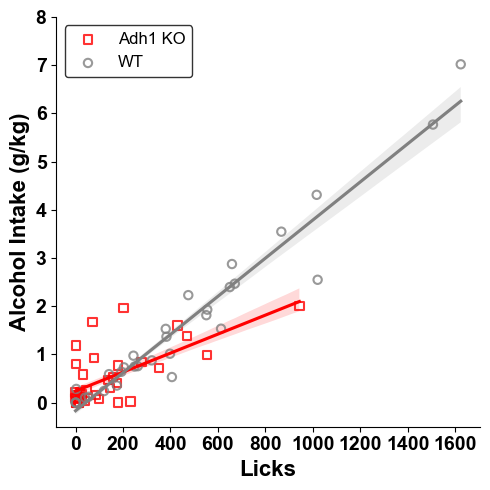

In [8]:
data = masterdrinker.pivot_table(values=['Lick'],
                                 index=['ID','Duration','Genotype','Intake','Sex'],
                                 aggfunc='sum')

data.reset_index(inplace=True)

data = data.loc[data['Genotype'].isin(['WT', 'Adh1 KO'])]

data['Genotype'] = data['Genotype'].astype('category')
data['Sex'] = data['Sex'].astype('category')
data['ID'] = data['ID'].astype('category')
data['Duration'] = data['Duration'].astype('category')

data.sort_values(by='Genotype', ascending=True)

sns.lmplot(data = data, x = 'Lick', y = 'Intake', hue = 'Genotype', ci=68, palette=['#FF0000','#808080'], markers=["s","o"], legend=False, scatter_kws={'facecolors':'none', 'linewidths':1.5})

plt.yticks(fontweight='bold', size = 14)
plt.ylabel("Alcohol Intake (g/kg)", size = 16, fontweight='bold')

plt.xticks(fontweight='bold', size = 14)
plt.xlabel("Licks", size = 16, fontweight='bold')

plt.legend(loc = 'upper left', fontsize = 12, edgecolor='black')

plt.ylim(-.5,8)

plt.tight_layout()
plt.savefig('raw_figs/alcohol_licks.pdf')


# Fit a mixed effects model
model = smf.mixedlm('Intake ~ Lick * Genotype', data, groups=data['ID']).fit()

# Print the summary of the model
print(model.summary())

# Retrieve p-values
p_values = model.pvalues

# Print significant p-values (e.g., p < 0.05)
significant_p_values = p_values[p_values < 0.05]
print(significant_p_values)

In [9]:
hypothesis = 'Lick:Genotype[T.WT] = 0'

# Perform the F-test
f_test_result = model.f_test(hypothesis)

# Print the F-test result
print(f_test_result)

<F test: F=22.760216707429272, p=1.1023681580937812e-05, df_denom=64, df_num=1>


                 Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      Intake  
No. Observations:        68           Method:                  REML    
No. Groups:              22           Scale:                   0.2618  
Min. group size:         1            Log-Likelihood:          -69.1343
Max. group size:         4            Converged:               Yes     
Mean group size:         3.1                                           
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     0.351    0.148  2.368 0.018  0.061  0.642
Genotype[T.WT]               -0.096    0.222 -0.432 0.665 -0.531  0.339
Lick_Duration                 0.015    0.006  2.676 0.007  0.004  0.026
Lick_Duration:Genotype[T.WT]  0.048    0.007  6.971 0.000  0.035  0.062
Group Var

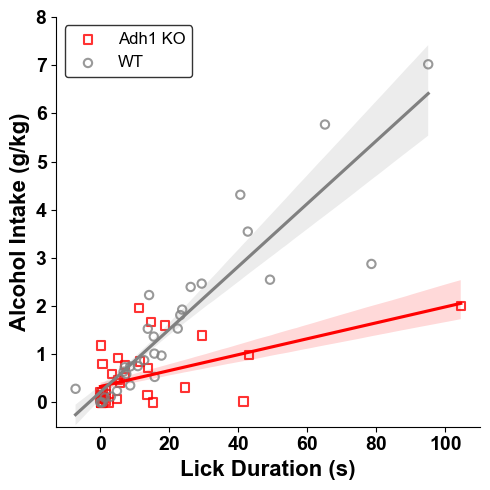

In [10]:
data = masterdrinker.pivot_table(values=['Lick_Duration'],
                                 index=['ID','Duration','Genotype','Intake','Sex'],
                                 aggfunc='sum')

data.reset_index(inplace=True)

data = data.loc[data['Genotype'].isin(['WT', 'Adh1 KO'])]

data['Genotype'] = data['Genotype'].astype('category')
data['Sex'] = data['Sex'].astype('category')
data['ID'] = data['ID'].astype('category')
data['Duration'] = data['Duration'].astype('category')

data['Lick_Duration'] = data['Lick_Duration']/1000

data.sort_values(by='Genotype', ascending=True)

sns.lmplot(data = data, x = 'Lick_Duration', y = 'Intake', hue = 'Genotype', ci=68, palette=['#FF0000','#808080'], markers=["s","o"], legend=False, scatter_kws={'facecolors':'none', 'linewidths':1.5})

plt.yticks(fontweight='bold', size = 14)
plt.ylabel("Alcohol Intake (g/kg)", size = 16, fontweight='bold')

plt.xticks(fontweight='bold', size = 14)
plt.xlabel("Lick Duration (s)", size = 16, fontweight='bold')

plt.legend(loc = 'upper left', fontsize = 12, edgecolor='black')

plt.ylim(-.5,8)

plt.tight_layout()
plt.savefig('raw_figs/alcohol_lickduration.pdf')


# Fit a mixed effects model
model = smf.mixedlm('Intake ~ Lick_Duration * Genotype', data, groups=data['ID']).fit()

# Print the summary of the model
print(model.summary())

# Retrieve p-values
p_values = model.pvalues

# Print significant p-values (e.g., p < 0.05)
significant_p_values = p_values[p_values < 0.05]
print(significant_p_values)

In [11]:
hypothesis = 'Lick_Duration:Genotype[T.WT] = 0'

# Perform the F-test
f_test_result = model.f_test(hypothesis)

# Print the F-test result
print(f_test_result)

<F test: F=48.59986017406526, p=2.088673400661776e-09, df_denom=64, df_num=1>


               Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     Intake  
No. Observations:       49          Method:                 REML    
No. Groups:             20          Scale:                  0.4884  
Min. group size:        1           Log-Likelihood:         -61.9838
Max. group size:        4           Converged:              Yes     
Mean group size:        2.5                                         
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                  0.456    0.224  2.032 0.042  0.016  0.896
Genotype[T.WT]            -0.685    0.358 -1.914 0.056 -1.386  0.016
BoutNumber                 0.032    0.017  1.836 0.066 -0.002  0.066
BoutNumber:Genotype[T.WT]  0.107    0.023  4.631 0.000  0.062  0.152
Group Var                  0.096    0.200         

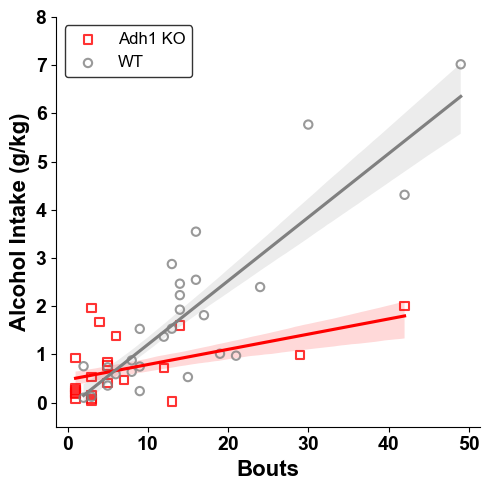

In [12]:
data = masterdrinker.pivot_table(values=['BoutNumber'],
                                 index=['ID','Duration','Genotype','Intake','Sex'],
                                 aggfunc='max')

data.reset_index(inplace=True)

data = data.loc[data['Genotype'].isin(['WT', 'Adh1 KO'])]

data['Genotype'] = data['Genotype'].astype('category')
data['Sex'] = data['Sex'].astype('category')
data['ID'] = data['ID'].astype('category')
data['Duration'] = data['Duration'].astype('category')

data.sort_values(by='Genotype', ascending=True)

sns.lmplot(data = data, x = 'BoutNumber', y = 'Intake', hue = 'Genotype', ci=68, palette=['#FF0000','#808080'], markers=["s","o"], legend=False, scatter_kws={'facecolors':'none', 'linewidths':1.5})

plt.yticks(fontweight='bold', size = 14)
plt.ylabel("Alcohol Intake (g/kg)", size = 16, fontweight='bold')

plt.xticks(fontweight='bold', size = 14)
plt.xlabel("Bouts", size = 16, fontweight='bold')

plt.legend(loc = 'upper left', fontsize = 12, edgecolor='black')

plt.ylim(-.5,8)

plt.tight_layout()
plt.savefig('raw_figs/alcohol_bouts.pdf')


# Fit a mixed effects model
model = smf.mixedlm('Intake ~ BoutNumber * Genotype', data, groups=data['ID']).fit()

# Print the summary of the model
print(model.summary())

# Retrieve p-values
p_values = model.pvalues

# Print significant p-values (e.g., p < 0.05)
significant_p_values = p_values[p_values < 0.05]
print(significant_p_values)

In [13]:
hypothesis = 'BoutNumber:Genotype[T.WT] = 0'

# Perform the F-test
f_test_result = model.f_test(hypothesis)

# Print the F-test result
print(f_test_result)

<F test: F=21.44208557407518, p=3.112841536895921e-05, df_denom=45, df_num=1>


                  W      pval  normal
Genotype                             
Adh1 KO    8.906056  0.011643   False
WT        21.066787  0.000027   False
     U-val alternative     p-val       RBC      CLES
MWU  839.5   two-sided  0.001059  0.463819  0.731909
Z-value: 3.2754125244288774


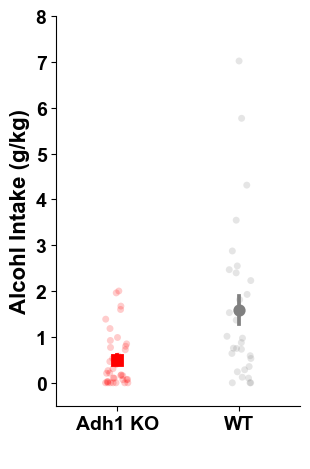

In [14]:
data = masterdrinker.pivot_table(values=['Lick'],
                                 index=['ID','Duration','Genotype','Intake','Sex'],
                                 aggfunc='sum')

data.reset_index(inplace=True)

data = data.loc[data['Genotype'].isin(['WT', 'Adh1 KO'])]

data.sort_values(by='Genotype', ascending=True)

plt.figure(figsize=(3.2, 4.8))  # Adjusted half witdth from default here

sns.stripplot(data = data, x = 'Genotype', hue = 'Genotype', y = 'Intake', palette=['#FF0000','#808080'], legend=False, alpha = 0.2)
sns.pointplot(data = data, x = 'Genotype', hue = 'Genotype', y = 'Intake', linestyle ='none', errorbar='se', palette=['#FF0000','#808080'], markers=["s","o"], legend=False)
sns.despine()

plt.yticks(fontweight='bold', size = 14)
plt.ylabel("Alcohl Intake (g/kg)", size = 16, fontweight='bold')

plt.xticks(fontweight='bold', size = 14)
plt.xlabel(" ", size = 16, fontweight='bold')

plt.ylim(-.5,8)

plt.tight_layout()
plt.savefig('raw_figs/alcohol_intake.pdf')

print(pg.normality(data = data, dv = 'Intake', group='Genotype',  method="jarque_bera"))

print(pg.mwu(data.loc[data['Genotype'] == 'WT', "Intake"], data.loc[data['Genotype'] == 'Adh1 KO', "Intake"]))

# Sample sizes
n1 = len(data.loc[data['Genotype'] == 'WT', "Intake"])
n2 = len(data.loc[data['Genotype'] == 'Adh1 KO', "Intake"])

# Mann-Whitney U statistic 
U = pg.mwu(data.loc[data['Genotype'] == 'WT', "Intake"], data.loc[data['Genotype'] == 'Adh1 KO', "Intake"])
U = U['U-val'].iloc[0]

# Calculate mean and standard deviation of U
mu_U = (n1 * n2) / 2
sigma_U = np.sqrt((n1 * n2 * (n1 + n2 + 1)) / 12)

# Calculate z-value
z = (U - mu_U) / sigma_U

print("Z-value:", z)

## Time Domain Analyses

In [15]:
# Initialize master_drinker as an empty DataFrame
cummulative_licks = pd.DataFrame()

for i in masterdrinker['ID'].unique():
    for j in masterdrinker.loc[masterdrinker['ID'] == i, 'Session'].unique():
        for k in masterdrinker.loc[(masterdrinker['ID'] == i) & (masterdrinker['Session'] == j), 'Duration'].unique():
            current_animal = masterdrinker.loc[(masterdrinker['ID'] == i) & (masterdrinker['Session'] == j) & (masterdrinker['Duration'] == k)]
                
            last_row = current_animal.iloc[-1].copy()
            
            if last_row['Duration'] == '4h':
                last_row['ElapsedTimeMinutes'] = 240
                last_row['ElapsedTime'] = pd.Timedelta(hours=4)
                
            if last_row['Duration'] == '2h':
                last_row['ElapsedTimeMinutes'] = 120
                last_row['ElapsedTime'] = pd.Timedelta(hours=2)

            last_row['Lick'] = np.nan
            last_row['Lick_Duration'] = np.nan
            last_row['ILI'] = np.nan
            last_row['DrinkStart'] = np.nan
            last_row['DrinkStop'] = np.nan
            
            current_animal = pd.concat([current_animal, last_row.to_frame().T], ignore_index = True)

            # Append the current_animal DataFrame to master_drinker
            cummulative_licks = pd.concat([cummulative_licks, current_animal], ignore_index=True)
                

/var/folders/yw/nqdj6w054pd5z6q9s87067d9vkpxp4/T/ipykernel_60096/2815198639.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  current_animal = pd.concat([current_animal, last_row.to_frame().T], ignore_index = True)
/var/folders/yw/nqdj6w054pd5z6q9s87067d9vkpxp4/T/ipykernel_60096/2815198639.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  current_animal = pd.concat([current_animal, last_row.to_frame().T], ignore_index = True)
/var/folders/yw/nqdj6w054pd5z6q9s87067d9vkpxp4/T/ipykernel_60096

### 2Hr

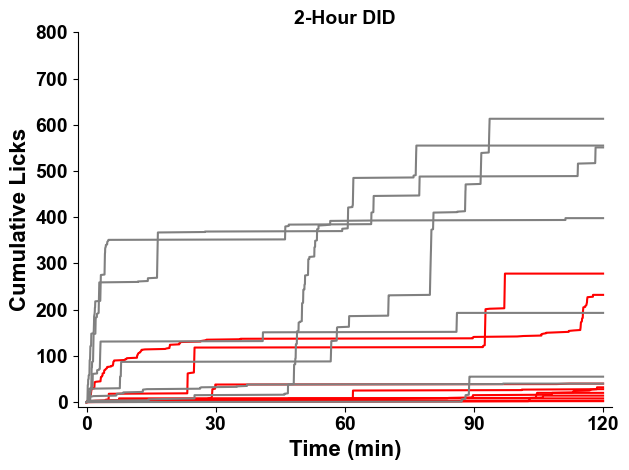

In [16]:
test = cummulative_licks.loc[cummulative_licks['Genotype'].isin(['WT', 'Adh1 KO'])]

test = test.loc[test['Session']<3]
test = test.loc[test['Duration'] == '2h']
test = test.loc[test['ElapsedTimeMinutes'] <= 120]

#lickometer error
test = test.loc[test['ID'] != 'WT11']
test = test.loc[test['ID'] != 'ADH8']

#no data
test = test.loc[test['ID'] != 'WT5']
test = test.loc[test['ID'] != 'WT13']

test.sort_values(by='Genotype', ascending=True)
test

sns.lineplot(data = test.sort_values(by='ID'), x = 'ElapsedTimeMinutes', y = 'Total_Licks', hue = 'ID', legend = False,
             palette= ['#FF0000', '#FF0000', '#FF0000', '#FF0000', '#FF0000', '#FF0000', '#FF0000', '#FF0000', '#FF0000', '#FF0000',
                       '#808080', '#808080', '#808080', '#808080', '#808080','#808080', '#808080'])

sns.despine()

plt.ylim(-10,800)
plt.xlim(-2,122)

plt.xticks([0,30,60,90,120])

plt.yticks(fontweight='bold', size = 14)
plt.ylabel("Cumulative Licks", size = 16, fontweight='bold')

plt.xticks(fontweight='bold', size = 14)
plt.xlabel("Time (min)", size = 16, fontweight='bold')

plt.title('2-Hour DID', fontweight = 'bold', size = 14)

plt.tight_layout()
plt.savefig('cumm_intakes_2HR_all.pdf')

<Figure size 640x960 with 0 Axes>

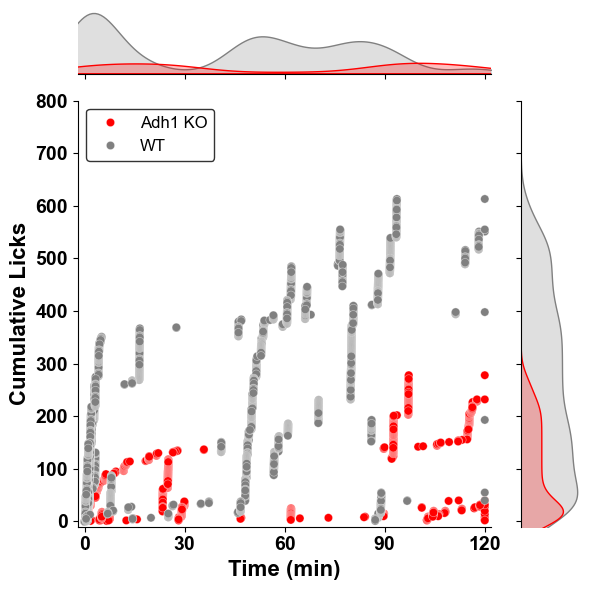

In [17]:
test = cummulative_licks.loc[cummulative_licks['Genotype'].isin(['WT', 'Adh1 KO'])]

test = test.loc[test['Session']<3]
test = test.loc[test['Duration'] == '2h']
test = test.loc[test['ElapsedTimeMinutes'] <= 120]

#lickometer error
test = test.loc[test['ID'] != 'WT11']
test = test.loc[test['ID'] != 'ADH8']

#no data
test = test.loc[test['ID'] != 'WT5']
test = test.loc[test['ID'] != 'WT13']

test.sort_values(by='Genotype', ascending=True)
test

plt.figure(figsize=(6.4, 9.6))  # Adjusted half witdth from default here

sns.jointplot(data = test.sort_values(by='Genotype'), x = 'ElapsedTimeMinutes', y = 'Total_Licks', hue = 'Genotype', legend=True, palette=['#FF0000','#808080'], edgecolor=(1, 1, 1, 0.5))
plt.ylim(-10,800)
plt.xlim(-2,122)

plt.xticks([0,30,60,90,120])

plt.xlabel("Time (min)")
plt.ylabel("Licks")

plt.yticks(fontweight='bold', size = 14)
plt.ylabel("Cumulative Licks", size = 16, fontweight='bold')

plt.xticks(fontweight='bold', size = 14)
plt.xlabel("Time (min)", size = 16, fontweight='bold')

plt.legend(loc = 'upper left', fontsize = 12, edgecolor='black')

plt.tight_layout()
plt.savefig('cumm_intakes_2HR_density.pdf')

KstestResult(statistic=array([0.39442275]), pvalue=array([8.52823116e-74]), statistic_location=array([91.71405]), statistic_sign=array([1.]))

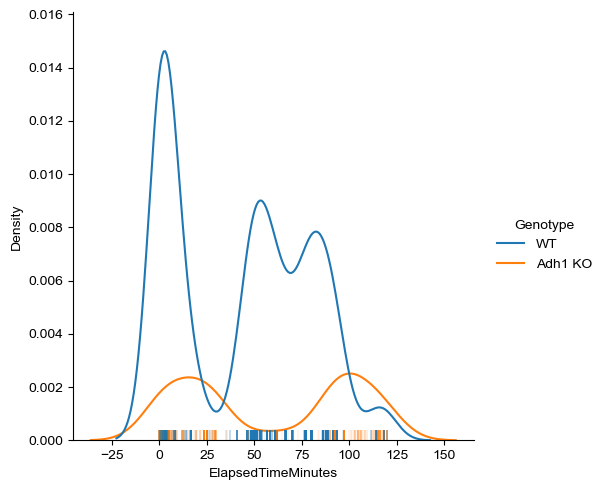

In [18]:
from scipy.stats import ks_2samp

sns.displot(data = test, x = 'ElapsedTimeMinutes', hue = 'Genotype', kind='kde', rug = True, rug_kws={"linewidth": 0.1})

ks_2samp(test.loc[test['Genotype'] == 'WT',['ElapsedTimeMinutes']], test.loc[test['Genotype'] == 'Adh1 KO',['ElapsedTimeMinutes']], alternative='two-sided')

KstestResult(statistic=array([0.42323852]), pvalue=array([2.69818491e-85]), statistic_location=array([232.]), statistic_sign=array([-1.]))

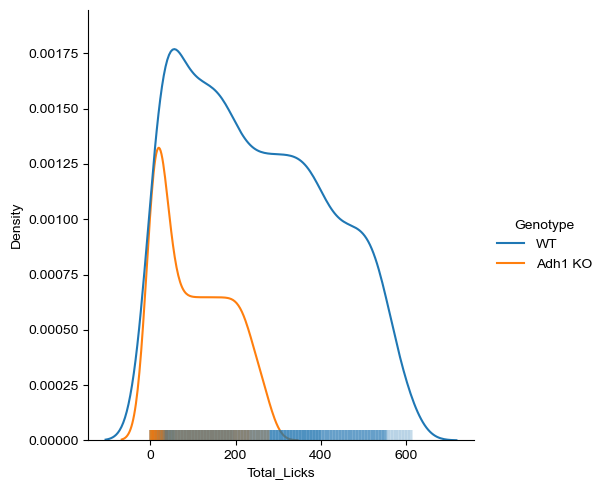

In [19]:
from scipy.stats import ks_2samp

sns.displot(data = test, x = 'Total_Licks', hue = 'Genotype', kind='kde', rug = True, rug_kws={"linewidth": 0.1})
ks_2samp(test.loc[test['Genotype'] == 'WT',['Total_Licks']], test.loc[test['Genotype'] == 'Adh1 KO',['Total_Licks']], alternative='two-sided')

                 W      pval  normal
Genotype                            
Adh1 KO   3.153010  0.206696    True
WT        1.017561  0.601228    True
     U-val alternative     p-val       RBC      CLES
MWU   51.5   two-sided  0.117969  0.471429  0.735714
Z-value: 1.6102351203650798


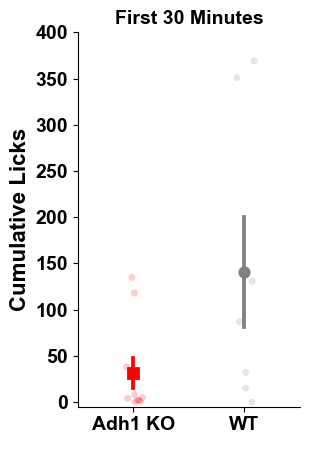

In [20]:
test = cummulative_licks.loc[cummulative_licks['Genotype'].isin(['WT', 'Adh1 KO'])]

test = test.loc[test['Session']<3]
test = test.loc[test['Duration'] == '2h']
test = test.loc[test['ElapsedTimeMinutes'] <= 120]

#lickometer error
test = test.loc[test['ID'] != 'WT11']
test = test.loc[test['ID'] != 'ADH8']

#no data
test = test.loc[test['ID'] != 'WT5']
test = test.loc[test['ID'] != 'WT13']

test.sort_values(by='Genotype', ascending=True)
test

test1 = test.loc[test['ElapsedTimeMinutes'] <= 30]

data = test1.pivot_table(values=['Total_Licks'],
                                 index=['ID','Duration','Genotype','Intake','Sex'],
                                 aggfunc='max')

data.reset_index(inplace=True)

data['Total_Licks'] = data['Total_Licks'].astype('float')

plt.figure(figsize=(3.2, 4.8))  # Adjusted half witdth from default here

sns.stripplot(data = data, x = 'Genotype', hue = 'Genotype', y = 'Total_Licks', palette=['#FF0000','#808080'], legend=False, alpha = 0.2)
sns.pointplot(data = data, x = 'Genotype', hue = 'Genotype', y = 'Total_Licks', linestyle ='none', errorbar='se', palette=['#FF0000','#808080'], markers=["s","o"], legend=False)
sns.despine()

plt.title('First 30 Minutes', fontweight = 'bold', size = 14)

plt.yticks(fontweight='bold', size = 14)
plt.ylabel("Cumulative Licks", size = 16, fontweight='bold')

plt.xticks(fontweight='bold', size = 14)
plt.xlabel(" ", size = 16, fontweight='bold')

plt.ylim(-5,400)

plt.tight_layout()
plt.savefig('2HR_frontload.pdf')

print(pg.normality(data = data, dv = 'Total_Licks', group='Genotype',  method="jarque_bera"))

print(pg.mwu(data.loc[data['Genotype'] == 'WT', "Total_Licks"], data.loc[data['Genotype'] == 'Adh1 KO', "Total_Licks"]))

# Sample sizes
n1 = len(data.loc[data['Genotype'] == 'WT', "Total_Licks"])
n2 = len(data.loc[data['Genotype'] == 'Adh1 KO', "Total_Licks"])

# Mann-Whitney U statistic 
U = pg.mwu(data.loc[data['Genotype'] == 'WT', "Total_Licks"], data.loc[data['Genotype'] == 'Adh1 KO', "Total_Licks"])
U = U['U-val'].iloc[0]

# Calculate mean and standard deviation of U
mu_U = (n1 * n2) / 2
sigma_U = np.sqrt((n1 * n2 * (n1 + n2 + 1)) / 12)

# Calculate z-value
z = (U - mu_U) / sigma_U

print("Z-value:", z)

                 W     pval  normal
Genotype                           
Adh1 KO   3.743298  0.15387    True
WT        0.852082  0.65309    True


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.832054,7.440685,two-sided,0.023773,"[48.62, 507.12]",1.598251,4.399,0.857654


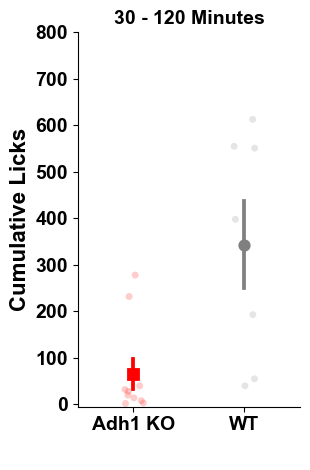

In [21]:
test = cummulative_licks.loc[cummulative_licks['Genotype'].isin(['WT', 'Adh1 KO'])]

test = test.loc[test['Session']<3]
test = test.loc[test['Duration'] == '2h']
test = test.loc[test['ElapsedTimeMinutes'] <= 120]

#lickometer error
test = test.loc[test['ID'] != 'WT11']
test = test.loc[test['ID'] != 'ADH8']

#no data
test = test.loc[test['ID'] != 'WT5']
test = test.loc[test['ID'] != 'WT13']

test.sort_values(by='Genotype', ascending=True)
test

test1 = test.loc[test['ElapsedTimeMinutes'] > 30]

data = test1.pivot_table(values=['Total_Licks'],
                                 index=['ID','Duration','Genotype','Intake','Sex'],
                                 aggfunc='max')

data.reset_index(inplace=True)

data['Total_Licks'] = data['Total_Licks'].astype('float')

plt.figure(figsize=(3.2, 4.8))  # Adjusted half witdth from default here

sns.stripplot(data = data, x = 'Genotype', hue = 'Genotype', y = 'Total_Licks', palette=['#FF0000','#808080'], legend=False, alpha = 0.2)
sns.pointplot(data = data, x = 'Genotype', hue = 'Genotype', y = 'Total_Licks', linestyle ='none', errorbar='se', palette=['#FF0000','#808080'], markers=["s","o"], legend=False)
sns.despine()

plt.title('30 - 120 Minutes', fontweight = 'bold', size = 14)

plt.yticks(fontweight='bold', size = 14)
plt.ylabel("Cumulative Licks", size = 16, fontweight='bold')

plt.xticks(fontweight='bold', size = 14)
plt.xlabel(" ", size = 16, fontweight='bold')

plt.ylim(-5,800)

plt.tight_layout()
plt.savefig('2HR_backload.pdf')

print(pg.normality(data = data, dv = 'Total_Licks', group='Genotype',  method="jarque_bera"))

pg.ttest(data.loc[data['Genotype'] == 'WT', "Total_Licks"], data.loc[data['Genotype'] == 'Adh1 KO', "Total_Licks"])

### 4Hr

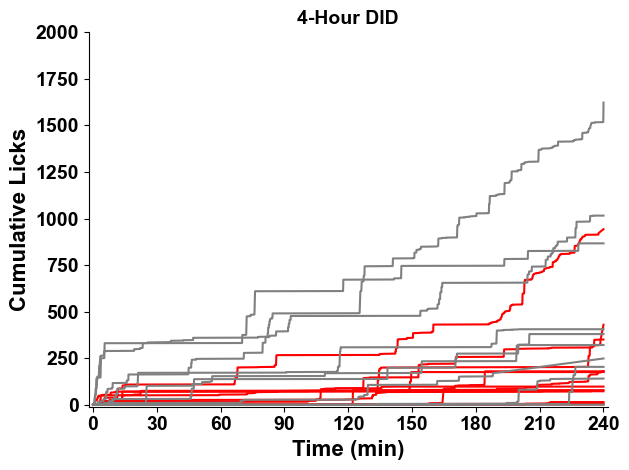

In [22]:
test = cummulative_licks.loc[cummulative_licks['Genotype'].isin(['WT', 'Adh1 KO'])]

test = test.loc[test['Session']<3]
test = test.loc[test['Duration'] == '4h']
test = test.loc[test['ElapsedTimeMinutes'] <= 240]

test.sort_values(by='Genotype', ascending=True)
test

sns.lineplot(data = test.sort_values(by='ID'), x = 'ElapsedTimeMinutes', y = 'Total_Licks', hue = 'ID', legend = False,
             palette= ['#FF0000', '#FF0000', '#FF0000', '#FF0000', '#FF0000', '#FF0000', '#FF0000','#FF0000', '#FF0000', '#FF0000', '#FF0000', '#FF0000',
                       '#808080', '#808080', '#808080','#808080', '#808080', '#808080', '#808080', '#808080', '#808080', '#808080'])

sns.despine()

plt.ylim(-10,2000)
plt.xlim(-2,242)

plt.xticks([0,30,60,90,120,150,180,210,240])
plt.yticks(fontweight='bold', size = 14)
plt.ylabel("Cumulative Licks", size = 16, fontweight='bold')

plt.xticks(fontweight='bold', size = 14)
plt.xlabel("Time (min)", size = 16, fontweight='bold')

plt.title('4-Hour DID', fontweight = 'bold', size = 14)

plt.tight_layout()
plt.savefig('cumm_intakes_4HR_all.pdf')

<Figure size 640x960 with 0 Axes>

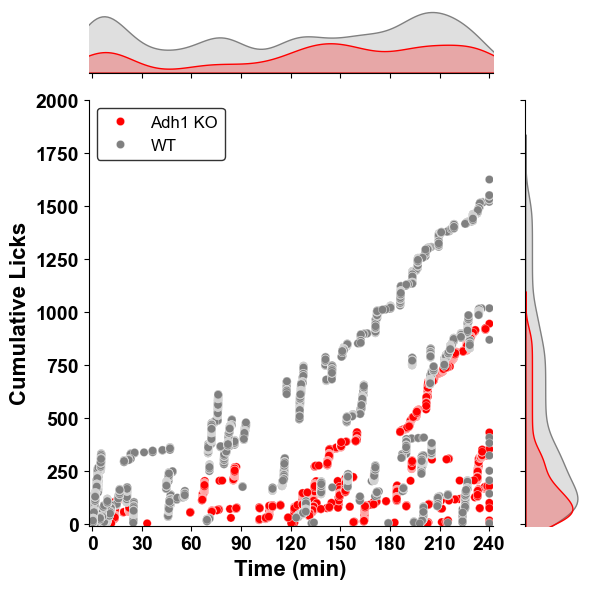

In [23]:
test = cummulative_licks.loc[cummulative_licks['Genotype'].isin(['WT', 'Adh1 KO'])]

test = test.loc[test['Session']<3]
test = test.loc[test['Duration'] == '4h']
test = test.loc[test['ElapsedTimeMinutes'] <= 240]

test.sort_values(by='Genotype', ascending=True)
test

plt.figure(figsize=(6.4, 9.6))  # Adjusted half witdth from default here

sns.jointplot(data = test.sort_values(by='Genotype'), x = 'ElapsedTimeMinutes', y = 'Total_Licks', hue = 'Genotype', legend=True, palette=['#FF0000','#808080'], edgecolor=(1, 1, 1, 0.5))

plt.ylim(-10,2000)
plt.xlim(-2,242)

plt.xticks([0,30,60,90,120,150,180,210,240])

plt.yticks(fontweight='bold', size = 14)
plt.ylabel("Cumulative Licks", size = 16, fontweight='bold')

plt.xticks(fontweight='bold', size = 14)
plt.xlabel("Time (min)", size = 16, fontweight='bold')

plt.legend(loc = 'upper left', fontsize = 12, edgecolor='black')

plt.tight_layout()
plt.savefig('cumm_intakes_4HR_density.pdf')

KstestResult(statistic=array([0.17118982]), pvalue=array([1.16474316e-42]), statistic_location=array([129.21766667]), statistic_sign=array([1.]))

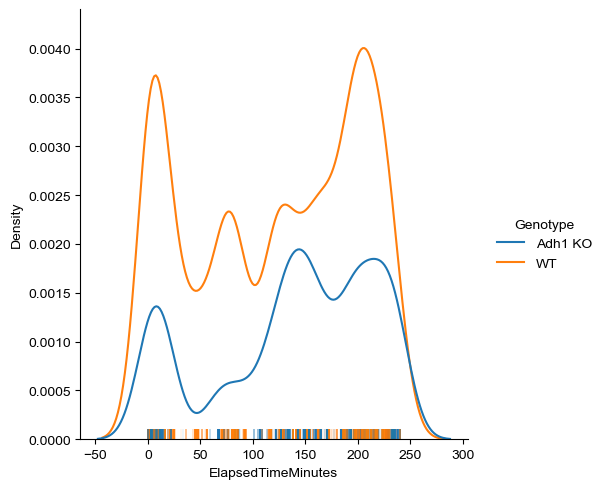

In [24]:
from scipy.stats import ks_2samp

sns.displot(data = test, x = 'ElapsedTimeMinutes', hue = 'Genotype', kind='kde', rug = True, rug_kws={"linewidth": 0.1})

ks_2samp(test.loc[test['Genotype'] == 'WT',['ElapsedTimeMinutes']], test.loc[test['Genotype'] == 'Adh1 KO',['ElapsedTimeMinutes']], alternative='two-sided')

KstestResult(statistic=array([0.25326256]), pvalue=array([2.13414133e-93]), statistic_location=array([345.]), statistic_sign=array([-1.]))

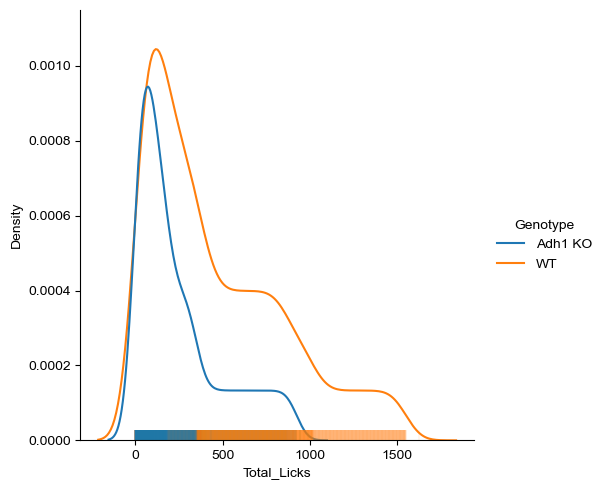

In [25]:
from scipy.stats import ks_2samp

sns.displot(data = test, x = 'Total_Licks', hue = 'Genotype', kind='kde', rug = True, rug_kws={"linewidth": 0.1})
ks_2samp(test.loc[test['Genotype'] == 'WT',['Total_Licks']], test.loc[test['Genotype'] == 'Adh1 KO',['Total_Licks']], alternative='two-sided')

                 W      pval  normal
Genotype                            
Adh1 KO   1.232913  0.539854    True
WT        1.282928  0.526521    True


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.826907,10.260151,two-sided,0.09691,"[-17.07, 175.57]",0.848385,1.212,0.470591


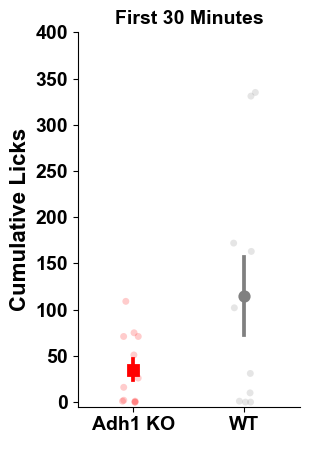

In [26]:
test = cummulative_licks.loc[cummulative_licks['Genotype'].isin(['WT', 'Adh1 KO'])]

test = test.loc[test['Session']<3]
test = test.loc[test['Duration'] == '4h']
test = test.loc[test['ElapsedTimeMinutes'] <= 240]

test.sort_values(by='Genotype', ascending=True)
test

test1 = test.loc[test['ElapsedTimeMinutes'] <= 30]

data = test1.pivot_table(values=['Total_Licks'],
                                 index=['ID','Duration','Genotype','Intake','Sex'],
                                 aggfunc='max')

data.reset_index(inplace=True)

data['Total_Licks'] = data['Total_Licks'].astype('float')

plt.figure(figsize=(3.2, 4.8))  # Adjusted half witdth from default here

sns.stripplot(data = data, x = 'Genotype', hue = 'Genotype', y = 'Total_Licks', palette=['#FF0000','#808080'], legend=False, alpha = 0.2)
sns.pointplot(data = data, x = 'Genotype', hue = 'Genotype', y = 'Total_Licks', linestyle ='none', errorbar='se', palette=['#FF0000','#808080'], markers=["s","o"], legend=False)
sns.despine()

plt.title('First 30 Minutes', fontweight = 'bold', size = 14)

plt.yticks(fontweight='bold', size = 14)
plt.ylabel("Cumulative Licks", size = 16, fontweight='bold')

plt.xticks(fontweight='bold', size = 14)
plt.xlabel(" ", size = 16, fontweight='bold')

plt.ylim(-5,400)

plt.tight_layout()
plt.savefig('4HR_frontload.pdf')

print(pg.normality(data = data, dv = 'Total_Licks', group='Genotype', method='jarque_bera'))

pg.ttest(data.loc[data['Genotype'] == 'WT', 'Total_Licks'],data.loc[data['Genotype'] == 'Adh1 KO', 'Total_Licks'])

                  W      pval  normal
Genotype                             
Adh1 KO   11.045079  0.003996   False
WT         2.324179  0.312832    True
     U-val alternative     p-val       RBC      CLES
MWU   88.0   two-sided  0.069786  0.466667  0.733333
Z-value: 1.8462653255082035


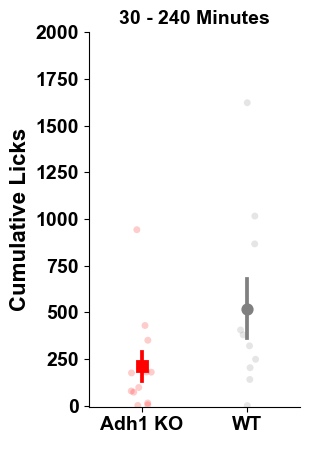

In [27]:
test = cummulative_licks.loc[cummulative_licks['Genotype'].isin(['WT', 'Adh1 KO'])]

test = test.loc[test['Session']<3]
test = test.loc[test['Duration'] == '4h']
test = test.loc[test['ElapsedTimeMinutes'] <= 240]

test.sort_values(by='Genotype', ascending=True)
test

test1 = test.loc[test['ElapsedTimeMinutes'] > 30]

data = test1.pivot_table(values=['Total_Licks'],
                                 index=['ID','Duration','Genotype','Intake','Sex'],
                                 aggfunc='max')

data.reset_index(inplace=True)

data['Total_Licks'] = data['Total_Licks'].astype('float')

plt.figure(figsize=(3.2, 4.8))  # Adjusted half witdth from default here

sns.stripplot(data = data, x = 'Genotype', hue = 'Genotype', y = 'Total_Licks', palette=['#FF0000','#808080'], legend=False, alpha = 0.2)
sns.pointplot(data = data, x = 'Genotype', hue = 'Genotype', y = 'Total_Licks', linestyle ='none', errorbar='se', palette=['#FF0000','#808080'], markers=["s","o"], legend=False)
sns.despine()

plt.title('30 - 240 Minutes', fontweight = 'bold', size = 14)

plt.yticks(fontweight='bold', size = 14)
plt.ylabel("Cumulative Licks", size = 16, fontweight='bold')

plt.xticks(fontweight='bold', size = 14)
plt.xlabel(" ", size = 16, fontweight='bold')

plt.ylim(-5,2000)

plt.tight_layout()
plt.savefig('4HR_backload.pdf')

print(pg.normality(data = data, dv = 'Total_Licks', group='Genotype', method='jarque_bera'))

print(pg.mwu(data.loc[data['Genotype'] == 'WT', 'Total_Licks'],data.loc[data['Genotype'] == 'Adh1 KO', 'Total_Licks']))

# Sample sizes
n1 = len(data.loc[data['Genotype'] == 'WT', "Total_Licks"])
n2 = len(data.loc[data['Genotype'] == 'Adh1 KO', "Total_Licks"])

# Mann-Whitney U statistic 
U = pg.mwu(data.loc[data['Genotype'] == 'WT', "Total_Licks"], data.loc[data['Genotype'] == 'Adh1 KO', "Total_Licks"])
U = U['U-val'].iloc[0]

# Calculate mean and standard deviation of U
mu_U = (n1 * n2) / 2
sigma_U = np.sqrt((n1 * n2 * (n1 + n2 + 1)) / 12)

# Calculate z-value
z = (U - mu_U) / sigma_U

print("Z-value:", z)

### Bouts Anaylsis

KstestResult(statistic=array([0.27252349]), pvalue=array([5.26739278e-177]), statistic_location=array([92.389]), statistic_sign=array([1.]))

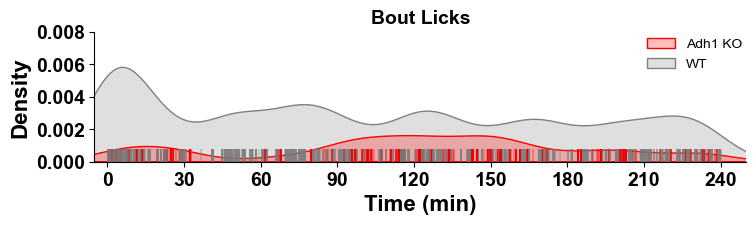

In [28]:
data = masterdrinker.loc[masterdrinker['Genotype'].isin(['WT', 'Adh1 KO'])]
data = data.loc[data['Lick_Duration'] >= 0]
data = data.loc[data['Lick_Duration'] <= 10000]
data = data.loc[data['Lick'] >= 0]
data = data.loc[data['Lick'] <= 1]
data = data.loc[data['ElapsedTimeMinutes'] <= 240]

data.loc[data['BoutNumber'].isnull(), 'Bout'] = 'Extra-Bouts'
data.loc[data['BoutNumber'].notnull(), 'Bout'] = "Within Bouts"

data = data.loc[data['Bout'] == 'Within Bouts']

g = sns.displot(data = data, x = 'ElapsedTimeMinutes', hue = 'Genotype', kind='kde', rug = True,  palette=['#FF0000','#808080'],
                rug_kws={"linewidth": 0.1, 'height':.1}, fill = True, height=2.2, aspect=3)

# Accessing the first axis in the FacetGrid
ax = g.ax

# Move the legend to the upper left
g.legend.set_bbox_to_anchor((.985,.775))  # Adjust position within figure
g.legend.set_title('')

plt.yticks(fontweight='bold', size = 14)
plt.ylabel("Density", size = 16, fontweight='bold')

plt.xticks(fontweight='bold', size = 14)
plt.xlabel("Time (min)", size = 16, fontweight='bold')

plt.xticks(fontweight='bold', size = 14)

plt.ylim(0,0.008)
plt.xlim(-5,250)
plt.xticks([0,30,60,90,120,150,180,210,240])

plt.tight_layout()
plt.title('Bout Licks',fontweight = 'bold', size = 14)

plt.savefig('BoutLick_Density.pdf')

from scipy.stats import ks_2samp
ks_2samp(data.loc[data['Genotype'] == 'WT',['ElapsedTimeMinutes']], data.loc[data['Genotype'] == 'Adh1 KO',['ElapsedTimeMinutes']], alternative='two-sided')

KstestResult(statistic=array([0.13634793]), pvalue=array([5.06815975e-13]), statistic_location=array([96.79606667]), statistic_sign=array([1.]))

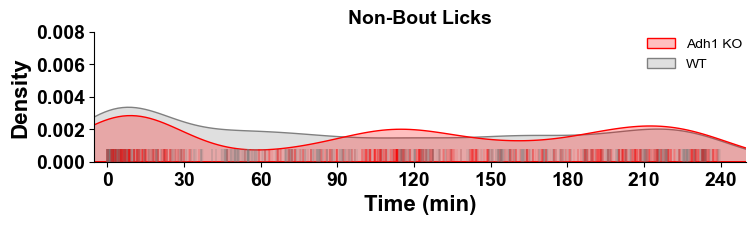

In [29]:
data = masterdrinker.loc[masterdrinker['Genotype'].isin(['WT', 'Adh1 KO'])]
data = data.loc[data['Lick_Duration'] >= 0]
data = data.loc[data['Lick_Duration'] <= 10000]
data = data.loc[data['Lick'] >= 0]
data = data.loc[data['Lick'] <= 1]
data = data.loc[data['ElapsedTimeMinutes'] <= 240]

data.loc[data['BoutNumber'].isnull(), 'Bout'] = 'Extra-Bouts'
data.loc[data['BoutNumber'].notnull(), 'Bout'] = "Within Bouts"

data = data.loc[data['Bout'] == 'Extra-Bouts']

g = sns.displot(data = data, x = 'ElapsedTimeMinutes', hue = 'Genotype', kind='kde', rug = True,  palette=['#FF0000','#808080'],
                rug_kws={"linewidth": 0.1, 'height':.1}, fill = True, height=2.2, aspect=3)

# Accessing the first axis in the FacetGrid
ax = g.ax

# Move the legend to the upper left
g.legend.set_bbox_to_anchor((.985,.775))  # Adjust position within figure
g.legend.set_title('')

plt.yticks(fontweight='bold', size = 14)
plt.ylabel("Density", size = 16, fontweight='bold')

plt.xticks(fontweight='bold', size = 14)
plt.xlabel("Time (min)", size = 16, fontweight='bold')

plt.xticks(fontweight='bold', size = 14)

plt.ylim(0,0.008)
plt.xlim(-5,250)
plt.xticks([0,30,60,90,120,150,180,210,240])

plt.tight_layout()
plt.title('Non-Bout Licks',fontweight = 'bold', size = 14)

plt.savefig('ExtraBoutLick_Density.pdf')

from scipy.stats import ks_2samp
ks_2samp(data.loc[data['Genotype'] == 'WT',['ElapsedTimeMinutes']], data.loc[data['Genotype'] == 'Adh1 KO',['ElapsedTimeMinutes']], alternative='two-sided')

                  W      pval  normal
Genotype                             
Adh1 KO   10.289706  0.005829   False
WT         5.732933  0.056900    True
     U-val alternative     p-val       RBC      CLES
MWU  469.0   two-sided  0.000566  0.579125  0.789562
Z-value: 3.4573300844916894


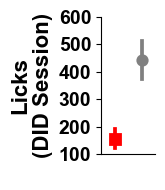

In [30]:
data = masterdrinker.loc[masterdrinker['Genotype'].isin(['WT', 'Adh1 KO'])]
data = data.loc[data['Lick_Duration'] >= 0]
data = data.loc[data['Lick_Duration'] <= 10000]
data = data.loc[data['Lick'] >= 0]
data = data.loc[data['Lick'] <= 1]
data = data.loc[data['ElapsedTimeMinutes'] <= 240]

data.loc[data['BoutNumber'].isnull(), 'Bout'] = 'Extra-Bouts'
data.loc[data['BoutNumber'].notnull(), 'Bout'] = "Within Bouts"

data = data.loc[data['Bout'] == 'Within Bouts']

data = data.pivot_table(values=['Lick'],
                        index=['ID','Duration','Session','Genotype','Intake','Sex','Experiment'],
                        aggfunc='sum')
 
data.reset_index(inplace=True)

data

plt.figure(figsize=(1.75, 2))  # Adjusted half witdth from default here

#sns.stripplot(data = data, x = 'Genotype', hue = 'Genotype', y = 'Lick', palette=['#FF0000','#808080'], legend=False)
sns.pointplot(data = data, x = 'Genotype', hue = 'Genotype', y = 'Lick', linestyle ='none', errorbar='se', palette=['#FF0000','#808080'], markers=["s","o"], legend=False)

sns.despine()

# Remove x-axis labels and sub-labels
plt.xticks([], [])
plt.xlabel("")


plt.yticks(fontweight='bold', size = 14)
plt.ylabel("Licks\n(DID Session)", size = 16, fontweight='bold')

plt.xticks(fontweight='bold', size = 14)
plt.xlabel(" ", size = 16, fontweight='bold')

plt.yticks([100,200,300,400,500,600])

plt.tight_layout()

plt.savefig('BoutLick_Licks.pdf')

print(pg.normality(data = data, dv = 'Lick', group='Genotype', method='jarque_bera'))
print(pg.mwu(data.loc[data['Genotype'] == 'WT', 'Lick'],data.loc[data['Genotype'] == 'Adh1 KO', 'Lick']))

# Sample sizes
n1 = len(data.loc[data['Genotype'] == 'WT', "Lick"])
n2 = len(data.loc[data['Genotype'] == 'Adh1 KO', "Lick"])

# Mann-Whitney U statistic 
U = pg.mwu(data.loc[data['Genotype'] == 'WT', "Lick"], data.loc[data['Genotype'] == 'Adh1 KO', "Lick"])
U = U['U-val'].iloc[0]

# Calculate mean and standard deviation of U
mu_U = (n1 * n2) / 2
sigma_U = np.sqrt((n1 * n2 * (n1 + n2 + 1)) / 12)

# Calculate z-value
z = (U - mu_U) / sigma_U

print("Z-value:", z)

                   W          pval  normal
Genotype                                  
Adh1 KO   118.477577  1.874654e-26   False
WT        114.910080  1.115817e-25   False
     U-val alternative     p-val      RBC      CLES
MWU  659.5   two-sided  0.077708  0.25619  0.628095
Z-value: 1.7698900594417786


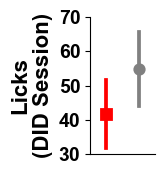

In [57]:
data = masterdrinker.loc[masterdrinker['Genotype'].isin(['WT', 'Adh1 KO'])]
data = data.loc[data['Lick_Duration'] >= 0]
data = data.loc[data['Lick_Duration'] <= 10000]
data = data.loc[data['Lick'] >= 0]
data = data.loc[data['Lick'] <= 1]
data = data.loc[data['ElapsedTimeMinutes'] <= 240]

data.loc[data['BoutNumber'].isnull(), 'Bout'] = 'Extra-Bouts'
data.loc[data['BoutNumber'].notnull(), 'Bout'] = "Within Bouts"

data = data.loc[data['Bout'] == 'Extra-Bouts']

data = data.pivot_table(values=['Lick'],
                        index=['ID','Duration','Session','Genotype','Intake','Sex'],
                        aggfunc='sum')
 
data.reset_index(inplace=True)

data

plt.figure(figsize=(1.75, 2))  # Adjusted half witdth from default here

#sns.stripplot(data = data, x = 'Genotype', hue = 'Genotype', y = 'Lick', palette=['#FF0000','#808080'], legend=False)
sns.pointplot(data = data, x = 'Genotype', hue = 'Genotype', y = 'Lick', linestyle ='none', errorbar='se', palette=['#FF0000','#808080'], markers=["s","o"], legend=False)

sns.despine()

# Remove x-axis labels and sub-labels
plt.xticks([], [])
plt.xlabel("")

plt.yticks(fontweight='bold', size = 14)
plt.ylabel("Licks\n(DID Session)", size = 16, fontweight='bold')

plt.xticks(fontweight='bold', size = 14)
plt.xlabel(" ", size = 16, fontweight='bold')

plt.yticks([30,40,50,60,70])

plt.tight_layout()


plt.savefig('EXTRABoutLick_Licks.pdf')

print(pg.normality(data = data, dv = 'Lick', group='Genotype', method='jarque_bera'))
print(pg.mwu(data.loc[data['Genotype'] == 'WT', 'Lick'],data.loc[data['Genotype'] == 'Adh1 KO', 'Lick']))

# Sample sizes
n1 = len(data.loc[data['Genotype'] == 'WT', "Lick"])
n2 = len(data.loc[data['Genotype'] == 'Adh1 KO', "Lick"])

# Mann-Whitney U statistic 
U = pg.mwu(data.loc[data['Genotype'] == 'WT', "Lick"], data.loc[data['Genotype'] == 'Adh1 KO', "Lick"])
U = U['U-val'].iloc[0]

# Calculate mean and standard deviation of U
mu_U = (n1 * n2) / 2
sigma_U = np.sqrt((n1 * n2 * (n1 + n2 + 1)) / 12)

# Calculate z-value
z = (U - mu_U) / sigma_U

print("Z-value:", z)

                  W          pval  normal
Genotype                                 
Adh1 KO    4.344054  1.139464e-01    True
WT        28.951832  5.166418e-07   False
     U-val alternative     p-val       RBC      CLES
MWU  213.5   two-sided  0.000037 -0.593333  0.203333
Z-value: 4.09903905959936


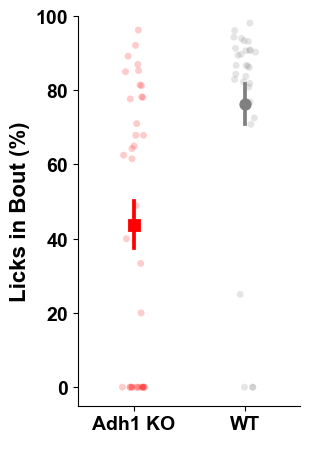

In [33]:
data = masterdrinker.loc[masterdrinker['Genotype'].isin(['WT', 'Adh1 KO'])]
data = data.loc[data['Lick'] >= 0]
data = data.loc[data['Lick'] <= 1]
data = data.loc[data['Lick_Duration'] >= 0]
data = data.loc[data['Lick_Duration'] <= 10000]
data['Lick_Duration'] = data['Lick_Duration']/1000

data.loc[data['BoutNumber'].isnull(), 'Bout'] = 'Extra-Bouts'
data.loc[data['BoutNumber'].notnull(), 'Bout'] = "Within Bouts"

for i in data['ID'].unique():
    for j in data.loc[data['ID'] == i,'Experiment'].unique():
        for k in data.loc[(data['ID'] == i) & (data['Experiment'] == j),'Session'].unique():
            current_animal = data.loc[(data['ID'] == i) & (data['Experiment'] == j) & (data['Session'] == k)]
            BoutPercent = current_animal.loc[current_animal['BoutNumber'].notnull(),'Lick'].count() / (current_animal.loc[current_animal['BoutNumber'].isnull(),'Lick'].count() + current_animal.loc[current_animal['BoutNumber'].notnull(),'Lick'].count())*100
            data.loc[(data['ID'] == i) & (data['Experiment'] == j) & (data['Session'] == k), 'BoutPercent'] = BoutPercent
            

data = data.pivot_table(values=['BoutPercent'],
                        index=['ID','Duration','Session','Genotype','Sex','Experiment'],
                        aggfunc='max')

data.reset_index(inplace=True)

data


plt.figure(figsize=(3.2, 4.8))  # Adjusted half witdth from default here

sns.stripplot(data = data, x = 'Genotype', hue = 'Genotype', y = 'BoutPercent', palette=['#FF0000','#808080'], legend=False, alpha = 0.2, linewidth=0)
sns.pointplot(data = data, x = 'Genotype', hue = 'Genotype', y = 'BoutPercent', linestyle ='none', errorbar='se', palette=['#FF0000','#808080'], markers=["s","o"], legend=False)

sns.despine()

plt.yticks(fontweight='bold', size = 14)
plt.ylabel("Licks in Bout (%)", size = 16, fontweight='bold')

plt.xticks(fontweight='bold', size = 14)
plt.xlabel(" ", size = 16, fontweight='bold')

plt.ylim(-5,100)

plt.tight_layout()
plt.savefig('boutpercents.pdf')

print(pg.normality(data = data, dv = 'BoutPercent', group='Genotype',  method="jarque_bera"))

print(pg.mwu(data.loc[data['Genotype'] == "Adh1 KO", "BoutPercent"], data.loc[data['Genotype'] == "WT", "BoutPercent"]))

# Sample sizes
n1 = len(data.loc[data['Genotype'] == 'WT', "BoutPercent"])
n2 = len(data.loc[data['Genotype'] == 'Adh1 KO', "BoutPercent"])

# Mann-Whitney U statistic 
U = pg.mwu(data.loc[data['Genotype'] == 'WT', "BoutPercent"], data.loc[data['Genotype'] == 'Adh1 KO', "BoutPercent"])
U = U['U-val'].iloc[0]

# Calculate mean and standard deviation of U
mu_U = (n1 * n2) / 2
sigma_U = np.sqrt((n1 * n2 * (n1 + n2 + 1)) / 12)

# Calculate z-value
z = (U - mu_U) / sigma_U

print("Z-value:", z)

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,Genotype,19222.559906,1,18,19222.559906,4.383291,0.050719,0.195829,NaN
1,Bout,45990.689248,1,18,45990.689248,20.292270,0.000274,0.529931,1.0
2,Interaction,11229.781942,1,18,11229.781942,4.954867,0.039032,0.215853,NaN


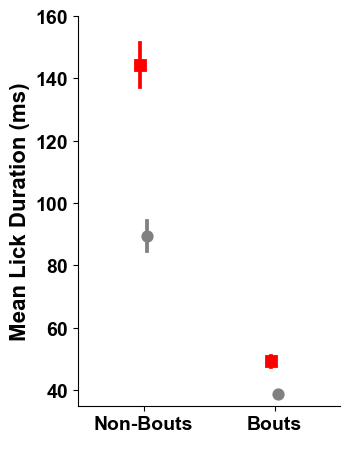

In [65]:
data = masterdrinker.loc[masterdrinker['Genotype'].isin(['WT', 'Adh1 KO'])]
data = data.loc[data['Lick'] >= 0]
data = data.loc[data['Lick'] <= 1]
data = data.loc[data['Lick_Duration'] >= 0]
data = data.loc[data['Lick_Duration'] <= 10000]
data = data.loc[data['ElapsedTimeMinutes'] <= 240]

data.loc[data['BoutNumber'].isnull(), 'Bout'] = 'Non-Bouts'
data.loc[data['BoutNumber'].notnull(), 'Bout'] = "Bouts"

plt.figure(figsize=(3.6, 4.8))  # Adjusted half witdth from default here

sns.pointplot(data = data, x = "Bout", y = 'Lick_Duration', hue = "Genotype",  linestyle ='none', errorbar='se', palette=['#FF0000','#808080'], markers=["s","o"], dodge =True, legend=False)

sns.despine()

plt.ylim(35,160)

plt.yticks(fontweight='bold', size = 14)
plt.ylabel("Mean Lick Duration (ms)", size = 16, fontweight='bold')

plt.xticks(fontweight='bold', size = 14)
plt.xlabel(" ", size = 16, fontweight='bold')

plt.tight_layout()
plt.savefig('boutDurations.pdf')

pg.mixed_anova(data= data, dv = 'Lick_Duration', between='Genotype', within='Bout', subject='ID')

In [61]:
pg.pairwise_tests(data= data, dv = 'Lick_Duration', between='Genotype', within='Bout', subject='ID')

,Contrast,Bout,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,Bout,-,Bouts,Non-Bouts,True,True,-4.098309,19.0,two-sided,0.000612,56.126,-1.057299
1,Genotype,-,Adh1 KO,WT,False,True,2.093631,18.0,two-sided,0.050719,1.685,0.896738
2,Bout * Genotype,Bouts,Adh1 KO,WT,False,True,1.415946,18.0,two-sided,0.173863,0.791,0.606474
3,Bout * Genotype,Non-Bouts,Adh1 KO,WT,False,True,2.164562,18.0,two-sided,0.044108,1.847,0.927119


                  W          pval  normal
Genotype                                 
Adh1 KO   44.050060  2.720514e-10   False
WT        18.454489  9.832380e-05   False
     U-val alternative     p-val      RBC     CLES
MWU  128.5   two-sided  0.000707 -0.56734  0.21633
Z-value: 3.3869774374235444


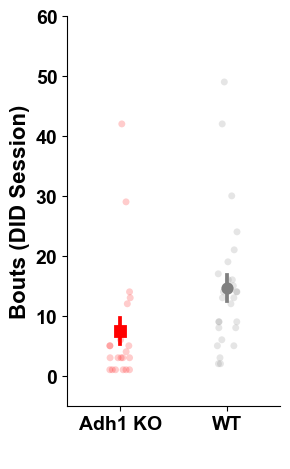

In [62]:
data = masterdrinker.loc[masterdrinker['Genotype'].isin(['WT', 'Adh1 KO'])]
data = data.loc[data['Lick'] >= 0]
data = data.loc[data['Lick'] <= 1]
data = data.loc[data['Lick_Duration'] >= 0]
data = data.loc[data['Lick_Duration'] <= 10000]
data['Lick_Duration'] = data['Lick_Duration']/1000

data.loc[data['BoutNumber'].isnull(), 'Bout'] = 'Extra-Bouts'
data.loc[data['BoutNumber'].notnull(), 'Bout'] = "Within Bouts"

data = data.pivot_table(values=['BoutNumber'],
                        index=['ID','Duration','Session','Genotype','Sex','Experiment'],
                        aggfunc='max')

data.reset_index(inplace=True)

plt.figure(figsize=(3, 4.8))  # Adjusted half witdth from default here

sns.stripplot(data = data, x = "Genotype", y = 'BoutNumber', hue = "Genotype",
              palette=['#FF0000','#808080'], alpha = 0.2)


sns.pointplot(data = data, x = "Genotype", y = 'BoutNumber', hue = "Genotype", linestyle ='none', errorbar='se',
              palette=['#FF0000','#808080'], markers=["s","o"], legend=False, estimator=np.mean)

sns.despine()

plt.ylim(-5,60)

plt.yticks(fontweight='bold', size = 14)
plt.ylabel("Bouts (DID Session)", size = 16, fontweight='bold')

plt.xticks(fontweight='bold', size = 14)
plt.xlabel(" ", size = 16, fontweight='bold')

plt.tight_layout()
plt.savefig('boutcounts.pdf')

print(pg.normality(data = data, dv = 'BoutNumber', group='Genotype',  method="jarque_bera"))
print(pg.mwu(data.loc[data['Genotype'] == "Adh1 KO", "BoutNumber"], data.loc[data['Genotype'] == "WT", "BoutNumber"]))
# Sample sizes
n1 = len(data.loc[data['Genotype'] == 'WT', "BoutNumber"])
n2 = len(data.loc[data['Genotype'] == 'Adh1 KO', "BoutNumber"])

# Mann-Whitney U statistic 
U = pg.mwu(data.loc[data['Genotype'] == 'WT', "BoutNumber"], data.loc[data['Genotype'] == 'Adh1 KO', "BoutNumber"])
U = U['U-val'].iloc[0]

# Calculate mean and standard deviation of U
mu_U = (n1 * n2) / 2
sigma_U = np.sqrt((n1 * n2 * (n1 + n2 + 1)) / 12)

# Calculate z-value
z = (U - mu_U) / sigma_U

print("Z-value:", z)


                   W          pval  normal
Genotype                                  
Adh1 KO   206.910878  1.174556e-45   False
WT        291.385500  5.326507e-64   False
       U-val alternative         p-val       RBC      CLES
MWU  23518.0   two-sided  5.403705e-07 -0.269457  0.365271
Z-value: 5.0088360949449555


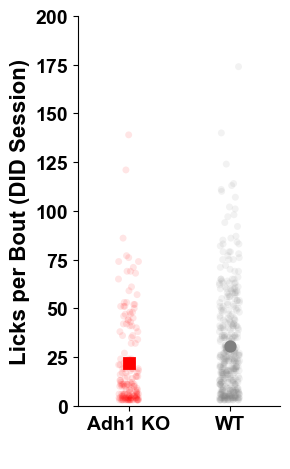

In [63]:
data = masterdrinker.loc[masterdrinker['Genotype'].isin(['WT', 'Adh1 KO'])]
data = data.loc[data['Lick'] >= 0]
data = data.loc[data['Lick'] <= 1]
data = data.loc[data['Lick_Duration'] >= 0]
data = data.loc[data['Lick_Duration'] <= 10000]
data['Lick_Duration'] = data['Lick_Duration']/1000

data.loc[data['BoutNumber'].isnull(), 'Bout'] = 'Extra-Bouts'
data.loc[data['BoutNumber'].notnull(), 'Bout'] = "Within Bouts"

data= data.loc[data['BoutNumber'].notnull()]

data = data.pivot_table(values=['LicksinBout'],
                        index=['ID','Duration','Session','Genotype','Sex','Experiment','BoutNumber'],
                        aggfunc='max')

data.reset_index(inplace=True)

data

plt.figure(figsize=(3, 4.8))  # Adjusted half witdth from default here

sns.stripplot(data = data, x = "Genotype", y = 'LicksinBout', hue = "Genotype",
              palette=['#FF0000','#808080'], alpha = 0.1)


sns.pointplot(data = data, x = "Genotype", y = 'LicksinBout', hue = "Genotype", linestyle ='none', errorbar='se',
              palette=['#FF0000','#808080'], markers=["s","o"], legend=False, estimator=np.mean)

sns.despine()

plt.yticks(fontweight='bold', size = 14)
plt.ylabel("Licks per Bout (DID Session)", size = 16, fontweight='bold')

plt.xticks(fontweight='bold', size = 14)
plt.xlabel(" ", size = 16, fontweight='bold')

plt.ylim(0,200)

plt.tight_layout()
plt.savefig('licksperbout.pdf')

print(pg.normality(data = data, dv = 'LicksinBout', group='Genotype',  method="jarque_bera"))

print(pg.mwu(data.loc[data['Genotype'] == "Adh1 KO", "LicksinBout"], data.loc[data['Genotype'] == "WT", "LicksinBout"]))

# Sample sizes
n1 = len(data.loc[data['Genotype'] == 'WT', "LicksinBout"])
n2 = len(data.loc[data['Genotype'] == 'Adh1 KO', "LicksinBout"])

# Mann-Whitney U statistic 
U = pg.mwu(data.loc[data['Genotype'] == 'WT', "LicksinBout"], data.loc[data['Genotype'] == 'Adh1 KO', "LicksinBout"])
U = U['U-val'].iloc[0]

# Calculate mean and standard deviation of U
mu_U = (n1 * n2) / 2
sigma_U = np.sqrt((n1 * n2 * (n1 + n2 + 1)) / 12)

# Calculate z-value
z = (U - mu_U) / sigma_U

print("Z-value:", z)


                   W          pval  normal
Genotype                                  
Adh1 KO    64.083948  1.214360e-14   False
WT        417.229955  2.509957e-91   False
       U-val alternative     p-val       RBC      CLES
MWU  29603.5   two-sided  0.135003 -0.080422  0.459789
Z-value: 1.4949422617802168


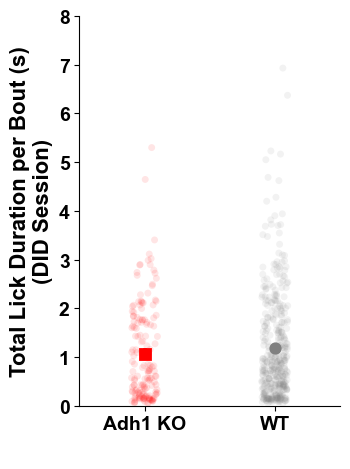

In [64]:
data = masterdrinker.loc[masterdrinker['Genotype'].isin(['WT', 'Adh1 KO'])]
data = data.loc[data['Lick'] >= 0]
data = data.loc[data['Lick'] <= 1]
data = data.loc[data['Lick_Duration'] >= 0]
data = data.loc[data['Lick_Duration'] <= 10000]
data = data.loc[data['LickDurationinBout'] > 0]
data['LickDurationinBout'] = data['LickDurationinBout']/1000

data.loc[data['BoutNumber'].isnull(), 'Bout'] = 'Extra-Bouts'
data.loc[data['BoutNumber'].notnull(), 'Bout'] = "Within Bouts"

data = data.pivot_table(values=['LickDurationinBout'],
                        index=['ID','Duration','Session','Genotype','Sex','Experiment','BoutNumber'],
                        aggfunc='max')

data.reset_index(inplace=True)

data

plt.figure(figsize=(3.6, 4.8))  # Adjusted half witdth from default here

sns.stripplot(data = data, x = "Genotype", y = 'LickDurationinBout', hue = "Genotype",
              palette=['#FF0000','#808080'], alpha = 0.1)

sns.pointplot(data = data, x = "Genotype", y = 'LickDurationinBout', hue = "Genotype", linestyle ='none', errorbar='se',
              palette=['#FF0000','#808080'], markers=["s","o"], legend=False, estimator=np.mean)

sns.despine()

plt.yticks(fontweight='bold', size = 14)
plt.ylabel("Total Lick Duration per Bout (s)\n(DID Session)", size = 16, fontweight='bold')

plt.xticks(fontweight='bold', size = 14)
plt.xlabel(" ", size = 16, fontweight='bold')
plt.ylim(0,8)

plt.tight_layout()
plt.savefig('lickdurationperbout.pdf')

print(pg.normality(data = data, dv = 'LickDurationinBout', group='Genotype',  method="jarque_bera"))

print(pg.mwu(data.loc[data['Genotype'] == "Adh1 KO", "LickDurationinBout"], data.loc[data['Genotype'] == "WT", "LickDurationinBout"]))


# Sample sizes
n1 = len(data.loc[data['Genotype'] == 'WT', "LickDurationinBout"])
n2 = len(data.loc[data['Genotype'] == 'Adh1 KO', "LickDurationinBout"])

# Mann-Whitney U statistic 
U = pg.mwu(data.loc[data['Genotype'] == 'WT', "LickDurationinBout"], data.loc[data['Genotype'] == 'Adh1 KO', "LickDurationinBout"])
U = U['U-val'].iloc[0]

# Calculate mean and standard deviation of U
mu_U = (n1 * n2) / 2
sigma_U = np.sqrt((n1 * n2 * (n1 + n2 + 1)) / 12)

# Calculate z-value
z = (U - mu_U) / sigma_U

print("Z-value:", z)


In [45]:
# Initialize master_drinker as an empty DataFrame
water = pd.DataFrame()

# Folder where CSV files are stored
folder_path = 'For Analysis'

# Function to construct file path
def get_file_path(date, folder_path):
    return os.path.join(folder_path, f"{date}")

# List to store DataFrames
dataframes = []

#files to search
datelist = master.loc[master['Experiment'] == 4,'File'].unique()

# Loop through dates and load corresponding CSV files
for i in datelist:
    file_path = get_file_path(i, folder_path)
    
    # Check if the file exists
    if os.path.exists(file_path):
        # Load the CSV file into a DataFrame and append to the list
        df = pd.read_csv(file_path)
        #assign date and time columns to datimetime elements and add them together to get the correctly formated datetime string with .100 millisecond precision
        df['DateTime'] = pd.to_datetime(df['MM-DD-YYYY'] + ' ' + df['HH:MM:SS.000'])
        #drop the old columns that we dont need
        df.drop(columns=['MM-DD-YYYY','HH:MM:SS.000'], inplace=True)
        
        print(f"Loaded {file_path}")
    else:
        print(f"File {file_path} does not exist.")
    for j in master.loc[master['File'] == i, 'ID'].unique():
        print(j)
        current_animal = df.loc[:, df.columns.str.contains(j) | df.columns.isin(['DateTime'])].copy()
        current_animal['ID'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'ID'].iloc[0]
        current_animal['Duration'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'SessionDuration'].iloc[0]
        current_animal['Experiment'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'Experiment'].iloc[0]
        current_animal['Genotype'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'Genotype'].iloc[0]
        current_animal['Sex'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'Sex'].iloc[0]
        current_animal['Fluid'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'Fluid'].iloc[0]
        current_animal['Intake'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'Intake'].iloc[0]
        
        # Create a dictionary for renaming columns containing '_Count' and '_Duration'
        rename_dict = {
            col: 'Total_Licks' if '_Count' in col else 'DrinkStart' if '_Start' in col else 'DrinkStop' if '_Stop' in col else col
            for col in current_animal.columns
        }
        # Rename the columns
        current_animal.rename(columns=rename_dict, inplace=True)
        
        #calulate the elpased time from the DrinkStop ofset to the start time to get real ms precsion
        current_animal['DateTime'] = current_animal['DateTime'][0] + pd.to_timedelta(current_animal['DrinkStop'], unit='ms') 
        
        #resort the index
        current_animal.set_index('DateTime', inplace=True)
        current_animal.sort_index(inplace=True)
        current_animal.reset_index(inplace=True)
        
        #calculate licks in binary
        current_animal['Lick'] = current_animal['Total_Licks'].diff()
        
        # #filter out data from other animals
        current_animal = current_animal.loc[current_animal['Lick'] != 0]
        
        #calulate the elpased time from the DrinkStop to match other data from first cohort
        current_animal['ElapsedTime'] = pd.to_timedelta(current_animal['DrinkStop'], unit='ms')
        
        #define lick duration from stop minus start
        current_animal['Lick_Duration'] = current_animal['DrinkStop'] - current_animal['DrinkStart']
        
        #calculate inter lick interval
        current_animal['ILI'] = current_animal['DrinkStart'] - current_animal['DrinkStop'].shift()
        current_animal['ILI'] = pd.to_timedelta(current_animal['ILI'], unit = 'ms')

        #bout start counter
        current_animal.set_index(current_animal['DateTime'] + pd.to_timedelta(current_animal['DrinkStart'], unit = 'ms'), inplace=True)
        current_animal.sort_index(inplace=True)
        current_animal['BoutStartCounter'] = current_animal['Lick'].rolling(window='1s').count()
        current_animal.reset_index(inplace=True)
        # Define conditions
        def boutstart_condition(row):
            return row['BoutStartCounter'] >= 3

        def boutstop_condition(row):
            return row['ILI'] >= pd.Timedelta('3 second')

        # Initialize variables
        start_index = None
        stop_index = None
        filtered_segments = []
        last_stop_index = None
        bout_counter = 1

        # Iterate through rows
        for index, row in current_animal.iterrows():
            if start_index is None:
                if boutstart_condition(row) or (last_stop_index is not None and index == last_stop_index + 1):
                    start_index = index
            elif boutstop_condition(row):
                stop_index = index - 1  # Set stop_index to the previous row
                
                # Create the filtered segment
                if stop_index >= start_index:
                    if len(current_animal.loc[start_index:stop_index]) >= 3:
                        current_animal.loc[start_index:stop_index, "BoutNumber"] = bout_counter
                        bout_counter = bout_counter+1
                
                # Update last_stop_index and reset for next segment
                last_stop_index = stop_index
                start_index = None
                stop_index = None

        # Handle the last segment if it doesn't end with a boutstop
        if start_index is not None:
            if len(current_animal.loc[start_index:stop_index]) >= 3:
                    current_animal.loc[start_index:stop_index, "BoutNumber"] = bout_counter
                    bout_counter = bout_counter+1
                    
        if 'BoutNumber' not in current_animal.columns:
            print('No Bouts!')
            current_animal['BoutNumber'] = np.nan
        
        #need to add a step for zero drinking mice to add bout_counter
        if current_animal.loc[0,'Intake'] == 0:
            print('sober mouse')
            current_animal['BoutNumber'] = np.nan
        
        #convert to datetime elements
        current_animal['DrinkStart'] = pd.to_timedelta(current_animal['DrinkStart'], unit='ms') + current_animal['DateTime'][0]
        current_animal['DrinkStop'] = pd.to_timedelta(current_animal['DrinkStop'], unit='ms') + current_animal['DateTime'][0]
        
        #lets clean up some things visually...
        current_animal = current_animal[['ID','Fluid','Sex','Genotype','Duration','Experiment','Intake','DrinkStart','DrinkStop','ElapsedTime','Total_Licks','Lick','Lick_Duration','ILI',"BoutNumber"]]

        if len(current_animal.loc[current_animal['BoutNumber'].notnull()]) > 0:
            for k in current_animal.loc[current_animal['BoutNumber'].notnull(), 'BoutNumber'].unique():
                current_animal.loc[current_animal['BoutNumber'] == k, 'LicksinBout'] = current_animal.loc[current_animal['BoutNumber'] == k, 'Lick'].sum()
                current_animal.loc[current_animal['BoutNumber'] == k, 'LickDurationinBout'] = current_animal.loc[current_animal['BoutNumber'] == k, 'Lick_Duration'].sum() 

        # Append the current_animal DataFrame to master_drinker
        water = pd.concat([water, current_animal], ignore_index=True)

    # Convert ElapsedTime to minutes for some ease in graphs
    water['ElapsedTimeMinutes'] = water['ElapsedTime'].dt.total_seconds()/60

water.head()

Loaded For Analysis/08072024_D2_Clean.csv
WT9
WT10
WT11
WT12
WT14
ADH9
ADH10
ADH11
ALDHKI1
ALDHKI2
ALDHKI3
No Bouts!
Loaded For Analysis/08072024_D1_Clean.csv
ADH12
ADH13
ADH14
ADH15
ALDH2
ALDH4


,ID,Fluid,Sex,Genotype,Duration,Experiment,Intake,DrinkStart,DrinkStop,ElapsedTime,Total_Licks,Lick,Lick_Duration,ILI,BoutNumber,LicksinBout,LickDurationinBout,ElapsedTimeMinutes
0,WT9,Water,Female,WT,4h,4,24.00722,2024-08-07 10:42:27.000,2024-08-07 10:42:27.000,0 days 00:00:00,0,NaN,0,NaT,NaN,NaN,NaN,0.000000
1,WT9,Water,Female,WT,4h,4,24.00722,2024-08-07 10:43:07.296,2024-08-07 10:43:07.332,0 days 00:00:40.332000,1,1.0,36,0 days 00:00:40.296000,NaN,NaN,NaN,0.672200
2,WT9,Water,Female,WT,4h,4,24.00722,2024-08-07 10:43:07.419,2024-08-07 10:43:07.449,0 days 00:00:40.449000,2,1.0,30,0 days 00:00:00.087000,NaN,NaN,NaN,0.674150
3,WT9,Water,Female,WT,4h,4,24.00722,2024-08-07 10:48:28.052,2024-08-07 10:48:28.070,0 days 00:06:01.070000,3,1.0,18,0 days 00:05:20.603000,NaN,NaN,NaN,6.017833
4,WT9,Water,Female,WT,4h,4,24.00722,2024-08-07 10:48:28.554,2024-08-07 10:48:28.596,0 days 00:06:01.596000,4,1.0,42,0 days 00:00:00.484000,NaN,NaN,NaN,6.026600


## Saccharin 

In [48]:
# Initialize master_drinker as an empty DataFrame
sacharrin = pd.DataFrame()

# Folder where CSV files are stored
folder_path = 'For Analysis'

# Function to construct file path
def get_file_path(date, folder_path):
    return os.path.join(folder_path, f"{date}")

# List to store DataFrames
dataframes = []

#files to search
datelist = master.loc[master['Experiment'] == 5,'File'].unique()

# Loop through dates and load corresponding CSV files
for i in datelist:
    file_path = get_file_path(i, folder_path)
    
    # Check if the file exists
    if os.path.exists(file_path):
        # Load the CSV file into a DataFrame and append to the list
        df = pd.read_csv(file_path)
        #assign date and time columns to datimetime elements and add them together to get the correctly formated datetime string with .100 millisecond precision
        df['DateTime'] = pd.to_datetime(df['MM-DD-YYYY'] + ' ' + df['HH:MM:SS.000'])
        #drop the old columns that we dont need
        df.drop(columns=['MM-DD-YYYY','HH:MM:SS.000'], inplace=True)
        
        print(f"Loaded {file_path}")
    else:
        print(f"File {file_path} does not exist.")
    for j in master.loc[master['File'] == i, 'ID'].unique():
        print(j)
        current_animal = df.loc[:, df.columns.str.contains(j) | df.columns.isin(['DateTime'])].copy()
        current_animal['ID'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'ID'].iloc[0]
        current_animal['Session'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'Session'].iloc[0]
        current_animal['Duration'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'SessionDuration'].iloc[0]
        current_animal['Experiment'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'Experiment'].iloc[0]
        current_animal['Genotype'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'Genotype'].iloc[0]
        current_animal['Sex'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'Sex'].iloc[0]
        current_animal['Fluid'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'Fluid'].iloc[0]
        current_animal['Intake'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'Intake'].iloc[0]
        
        # Create a dictionary for renaming columns containing '_Count' and '_Duration'
        rename_dict = {
            col: 'Total_Licks' if '_Count' in col else 'DrinkStart' if '_Start' in col else 'DrinkStop' if '_Stop' in col else col
            for col in current_animal.columns
        }
        # Rename the columns
        current_animal.rename(columns=rename_dict, inplace=True)
        
        #calulate the elpased time from the DrinkStop ofset to the start time to get real ms precsion
        current_animal['DateTime'] = current_animal['DateTime'][0] + pd.to_timedelta(current_animal['DrinkStop'], unit='ms') 
        
        #resort the index
        current_animal.set_index('DateTime', inplace=True)
        current_animal.sort_index(inplace=True)
        current_animal.reset_index(inplace=True)
        
        #calculate licks in binary
        current_animal['Lick'] = current_animal['Total_Licks'].diff()
        
        # #filter out data from other animals
        current_animal = current_animal.loc[current_animal['Lick'] != 0]
        
        #calulate the elpased time from the DrinkStop to match other data from first cohort
        current_animal['ElapsedTime'] = pd.to_timedelta(current_animal['DrinkStop'], unit='ms')
        
        #define lick duration from stop minus start
        current_animal['Lick_Duration'] = current_animal['DrinkStop'] - current_animal['DrinkStart']
        
        #calculate inter lick interval
        current_animal['ILI'] = current_animal['DrinkStart'] - current_animal['DrinkStop'].shift()
        current_animal['ILI'] = pd.to_timedelta(current_animal['ILI'], unit = 'ms')

        #bout start counter
        current_animal.set_index(current_animal['DateTime'] + pd.to_timedelta(current_animal['DrinkStart'], unit = 'ms'), inplace=True)
        current_animal.sort_index(inplace=True)
        current_animal['BoutStartCounter'] = current_animal['Lick'].rolling(window='1s').count()
        current_animal.reset_index(inplace=True)
        # Define conditions
        def boutstart_condition(row):
            return row['BoutStartCounter'] >= 3

        def boutstop_condition(row):
            return row['ILI'] >= pd.Timedelta('3 second')

        # Initialize variables
        start_index = None
        stop_index = None
        filtered_segments = []
        last_stop_index = None
        bout_counter = 1

        # Iterate through rows
        for index, row in current_animal.iterrows():
            if start_index is None:
                if boutstart_condition(row) or (last_stop_index is not None and index == last_stop_index + 1):
                    start_index = index
            elif boutstop_condition(row):
                stop_index = index - 1  # Set stop_index to the previous row
                
                # Create the filtered segment
                if stop_index >= start_index:
                    if len(current_animal.loc[start_index:stop_index]) >= 3:
                        current_animal.loc[start_index:stop_index, "BoutNumber"] = bout_counter
                        bout_counter = bout_counter+1
                
                # Update last_stop_index and reset for next segment
                last_stop_index = stop_index
                start_index = None
                stop_index = None

        # Handle the last segment if it doesn't end with a boutstop
        if start_index is not None:
            if len(current_animal.loc[start_index:stop_index]) >= 3:
                    current_animal.loc[start_index:stop_index, "BoutNumber"] = bout_counter
                    bout_counter = bout_counter+1
                    
        if 'BoutNumber' not in current_animal.columns:
            print('No Bouts!')
            current_animal['BoutNumber'] = np.nan
        
        #need to add a step for zero drinking mice to add bout_counter
        if current_animal.loc[0,'Intake'] == 0:
            print('sober mouse')
            current_animal['BoutNumber'] = np.nan
        
        #convert to datetime elements
        current_animal['DrinkStart'] = pd.to_timedelta(current_animal['DrinkStart'], unit='ms') + current_animal['DateTime'][0]
        current_animal['DrinkStop'] = pd.to_timedelta(current_animal['DrinkStop'], unit='ms') + current_animal['DateTime'][0]
        
        #lets clean up some things visually...
        current_animal = current_animal[['ID','Fluid','Sex','Genotype','Duration','Session','Experiment','Intake','DrinkStart','DrinkStop','ElapsedTime','Total_Licks','Lick','Lick_Duration','ILI',"BoutNumber"]]

        if len(current_animal.loc[current_animal['BoutNumber'].notnull()]) > 0:
            for k in current_animal.loc[current_animal['BoutNumber'].notnull(), 'BoutNumber'].unique():
                current_animal.loc[current_animal['BoutNumber'] == k, 'LicksinBout'] = current_animal.loc[current_animal['BoutNumber'] == k, 'Lick'].sum()
                current_animal.loc[current_animal['BoutNumber'] == k, 'LickDurationinBout'] = current_animal.loc[current_animal['BoutNumber'] == k, 'Lick_Duration'].sum() 

        # Append the current_animal DataFrame to master_drinker
        sacharrin = pd.concat([sacharrin, current_animal], ignore_index=True)

    # Convert ElapsedTime to minutes for some ease in graphs
    sacharrin['ElapsedTimeMinutes'] = sacharrin['ElapsedTime'].dt.total_seconds()/60

sacharrin.head()

Loaded For Analysis/08082024_D2_Clean.csv
WT9
WT10
WT11
WT12
WT13
No Bouts!
WT14
ADH9
ADH10
ADH11
ALDHKI1
ALDHKI2
ALDHKI3
Loaded For Analysis/08082024_D1_Clean.csv
ADH12
ADH13
ADH14
ADH15
ALDH2
ALDH3
ALDH4


,ID,Fluid,Sex,Genotype,Duration,Session,Experiment,Intake,DrinkStart,DrinkStop,ElapsedTime,Total_Licks,Lick,Lick_Duration,ILI,BoutNumber,LicksinBout,LickDurationinBout,ElapsedTimeMinutes
0,WT9,Saccharin,Female,WT,4h,1,5,43.3213,2024-08-08 10:53:22.000,2024-08-08 10:53:22.000,0 days 00:00:00,0,NaN,0,NaT,NaN,NaN,NaN,0.000000
1,WT9,Saccharin,Female,WT,4h,1,5,43.3213,2024-08-08 10:54:12.559,2024-08-08 10:54:12.595,0 days 00:00:50.595000,1,1.0,36,0 days 00:00:50.559000,NaN,NaN,NaN,0.843250
2,WT9,Saccharin,Female,WT,4h,1,5,43.3213,2024-08-08 10:54:12.890,2024-08-08 10:54:12.938,0 days 00:00:50.938000,2,1.0,48,0 days 00:00:00.295000,NaN,NaN,NaN,0.848967
3,WT9,Saccharin,Female,WT,4h,1,5,43.3213,2024-08-08 10:54:13.095,2024-08-08 10:54:13.143,0 days 00:00:51.143000,3,1.0,48,0 days 00:00:00.157000,NaN,NaN,NaN,0.852383
4,WT9,Saccharin,Female,WT,4h,1,5,43.3213,2024-08-08 10:54:13.336,2024-08-08 10:54:13.348,0 days 00:00:51.348000,4,1.0,12,0 days 00:00:00.193000,1.0,35.0,1738.0,0.855800


             Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    Intake  
No. Observations:    13         Method:                REML    
No. Groups:          13         Scale:                 69.7494 
Min. group size:     1          Log-Likelihood:        -50.8812
Max. group size:     1          Converged:             Yes     
Mean group size:     1.0                                       
---------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------
Intercept            1.609   10.347  0.156 0.876 -18.671 21.890
Genotype[T.WT]      -1.408   13.904 -0.101 0.919 -28.659 25.843
Lick                 0.038    0.014  2.694 0.007   0.010  0.066
Lick:Genotype[T.WT] -0.004    0.016 -0.232 0.816  -0.036  0.028
Group Var           69.749                                     

Lick    0.007054
dtype: float64


/Users/haggertydl/miniforge3/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


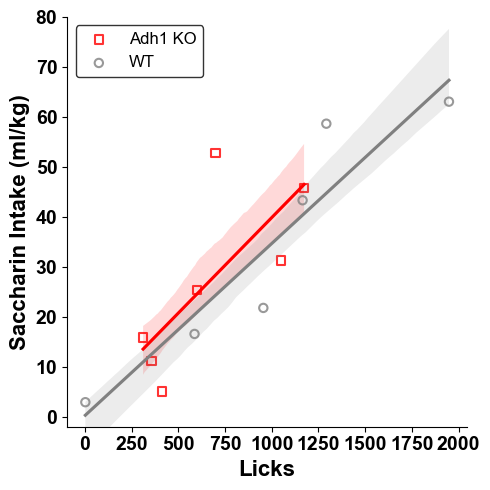

In [49]:
data = sacharrin.pivot_table(values=['Lick'],
                                 index=['ID','Duration','Genotype','Intake','Sex'],
                                 aggfunc='sum')

data.reset_index(inplace=True)

data = data.loc[data['Genotype'].isin(['WT', 'Adh1 KO'])]

data['Genotype'] = data['Genotype'].astype('category')
data['Sex'] = data['Sex'].astype('category')
data['ID'] = data['ID'].astype('category')
data['Duration'] = data['Duration'].astype('category')

data.sort_values(by='Genotype', ascending=True)

sns.lmplot(data = data, x = 'Lick', y = 'Intake', hue = 'Genotype', ci=68, palette=['#FF0000','#808080'], markers=["s","o"], legend=False, scatter_kws={'facecolors':'none', 'linewidths':1.5})

plt.yticks(fontweight='bold', size = 14)
plt.ylabel("Saccharin Intake (ml/kg)", size = 16, fontweight='bold')

plt.xticks(fontweight='bold', size = 14)
plt.xlabel("Licks", size = 16, fontweight='bold')

plt.legend(loc = 'upper left', fontsize = 12, edgecolor='black')

plt.ylim(-2,80)

plt.tight_layout()
plt.savefig('raw_figs/saccharin_licks.pdf')


# Fit a mixed effects model
model = smf.mixedlm('Intake ~ Lick * Genotype', data, groups=data['ID']).fit()

# Print the summary of the model
print(model.summary())

# Retrieve p-values
p_values = model.pvalues

# Print significant p-values (e.g., p < 0.05)
significant_p_values = p_values[p_values < 0.05]
print(significant_p_values)

In [50]:
hypothesis = 'Lick = 0'

# Perform the F-test
f_test_result = model.f_test(hypothesis)

# Print the F-test result
print(f_test_result)

<F test: F=7.259225783365413, p=0.02462268593277257, df_denom=9, df_num=1>


                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Intake  
No. Observations:       13            Method:                   REML    
No. Groups:             13            Scale:                    52.8124 
Min. group size:        1             Log-Likelihood:           -44.0685
Max. group size:        1             Converged:                Yes     
Mean group size:        1.0                                             
------------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------------
Intercept                     2.453    6.696  0.366 0.714 -10.671 15.577
Genotype[T.WT]               -4.223    3.151 -1.340 0.180 -10.399  1.952
Lick_Duration                 0.570    0.133  4.273 0.000   0.309  0.832
Lick_Duration:Genotype[T.WT]  0.119    0.091  1.307 0.191  -0.059  0.

/Users/haggertydl/miniforge3/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


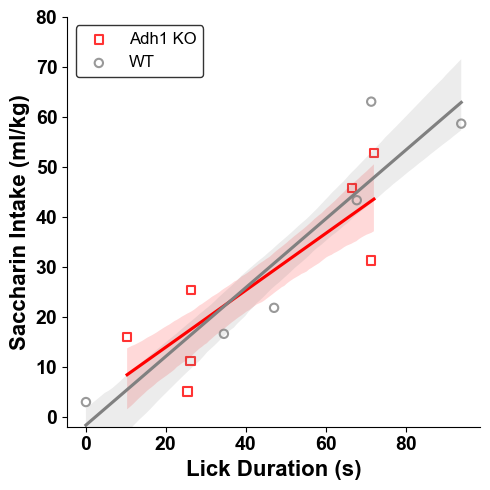

In [51]:
data = sacharrin.pivot_table(values=['Lick_Duration'],
                                 index=['ID','Duration','Genotype','Intake','Sex'],
                                 aggfunc='sum')

data.reset_index(inplace=True)

data = data.loc[data['Genotype'].isin(['WT', 'Adh1 KO'])]

data['Genotype'] = data['Genotype'].astype('category')
data['Sex'] = data['Sex'].astype('category')
data['ID'] = data['ID'].astype('category')
data['Duration'] = data['Duration'].astype('category')

data['Lick_Duration'] = data['Lick_Duration']/1000

data.sort_values(by='Genotype', ascending=True)

sns.lmplot(data = data, x = 'Lick_Duration', y = 'Intake', hue = 'Genotype', ci=68, palette=['#FF0000','#808080'], markers=["s","o"], legend=False, scatter_kws={'facecolors':'none', 'linewidths':1.5})

plt.yticks(fontweight='bold', size = 14)
plt.ylabel("Saccharin Intake (ml/kg)", size = 16, fontweight='bold')

plt.xticks(fontweight='bold', size = 14)
plt.xlabel("Lick Duration (s)", size = 16, fontweight='bold')

plt.legend(loc = 'upper left', fontsize = 12, edgecolor='black')

plt.ylim(-2,80)

plt.tight_layout()
plt.savefig('raw_figs/saccharin_lickduration.pdf')


# Fit a mixed effects model
model = smf.mixedlm('Intake ~ Lick_Duration * Genotype', data, groups=data['ID']).fit()

# Print the summary of the model
print(model.summary())

# Retrieve p-values
p_values = model.pvalues

# Print significant p-values (e.g., p < 0.05)
significant_p_values = p_values[p_values < 0.05]
print(significant_p_values)

In [52]:
hypothesis = 'Lick_Duration = 0'

# Perform the F-test
f_test_result = model.f_test(hypothesis)

# Print the F-test result
print(f_test_result)

<F test: F=18.2584606628993, p=0.002071179846313132, df_denom=9, df_num=1>


                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Intake  
No. Observations:      12           Method:                  REML    
No. Groups:            12           Scale:                   49.7364 
Min. group size:       1            Log-Likelihood:          -37.6007
Max. group size:       1            Converged:               Yes     
Mean group size:       1.0                                           
---------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------
Intercept                 -1.766    8.772 -0.201 0.840 -18.959 15.428
Genotype[T.WT]             6.160   13.405  0.460 0.646 -20.113 32.434
BoutNumber                 2.560    0.711  3.601 0.000   1.167  3.953
BoutNumber:Genotype[T.WT] -1.273    0.781 -1.631 0.103  -2.804  0.257
Group Var                 49.736    

/Users/haggertydl/miniforge3/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


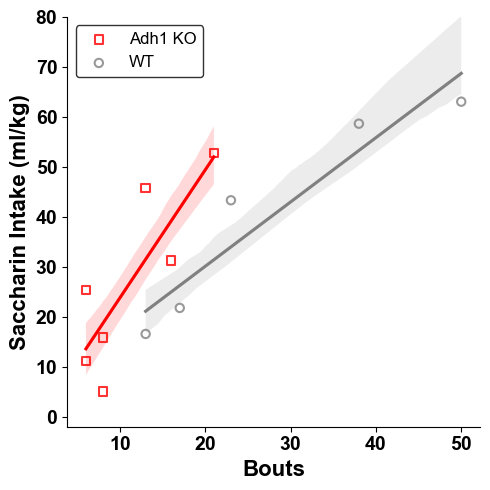

In [53]:
data = sacharrin.pivot_table(values=['BoutNumber'],
                                 index=['ID','Duration','Genotype','Intake','Sex'],
                                 aggfunc='max')

data.reset_index(inplace=True)

data = data.loc[data['Genotype'].isin(['WT', 'Adh1 KO'])]

data['Genotype'] = data['Genotype'].astype('category')
data['Sex'] = data['Sex'].astype('category')
data['ID'] = data['ID'].astype('category')
data['Duration'] = data['Duration'].astype('category')

data.sort_values(by='Genotype', ascending=True)

sns.lmplot(data = data, x = 'BoutNumber', y = 'Intake', hue = 'Genotype', ci=68, palette=['#FF0000','#808080'], markers=["s","o"], legend=False, scatter_kws={'facecolors':'none', 'linewidths':1.5})

plt.yticks(fontweight='bold', size = 14)
plt.ylabel("Saccharin Intake (ml/kg)", size = 16, fontweight='bold')

plt.xticks(fontweight='bold', size = 14)
plt.xlabel("Bouts", size = 16, fontweight='bold')

plt.legend(loc = 'upper left', fontsize = 12, edgecolor='black')

plt.ylim(-2,80)

plt.tight_layout()
plt.savefig('raw_figs/saccharin_bouts.pdf')

# Fit a mixed effects model
model = smf.mixedlm('Intake ~ BoutNumber * Genotype', data, groups=data['ID']).fit()

# Print the summary of the model
print(model.summary())

# Retrieve p-values
p_values = model.pvalues

# Print significant p-values (e.g., p < 0.05)
significant_p_values = p_values[p_values < 0.05]
print(significant_p_values)

In [55]:
hypothesis = 'BoutNumber = 0'

# Perform the F-test
f_test_result = model.f_test(hypothesis)

# Print the F-test result
print(f_test_result)

<F test: F=12.969406350247159, p=0.006969066443028784, df_denom=8, df_num=1>


                 W      pval  normal
Genotype                            
Adh1 KO   0.576235  0.749674    True
WT        0.588962  0.744918    True


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.635533,9.048018,two-sided,0.540819,"[-19.48, 34.72]",0.362717,0.521,0.091702


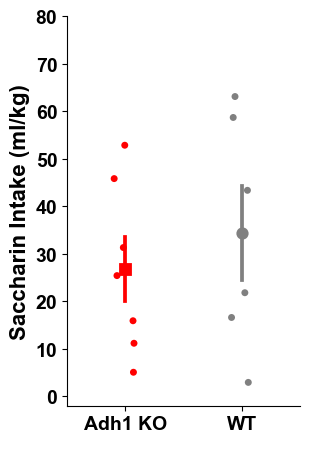

In [56]:
data = sacharrin.pivot_table(values=['Lick'],
                                 index=['ID','Duration','Genotype','Intake','Sex'],
                                 aggfunc='sum')

data.reset_index(inplace=True)

data = data.loc[data['Genotype'].isin(['WT', 'Adh1 KO'])]

data.sort_values(by='Genotype', ascending=True)

plt.figure(figsize=(3.2, 4.8))  # Adjusted half witdth from default here

sns.pointplot(data = data, x = 'Genotype', hue = 'Genotype', y = 'Intake', linestyle ='none', errorbar='se', palette=['#FF0000','#808080'], markers=["s","o"], legend=False)
sns.stripplot(data = data, x = 'Genotype', hue = 'Genotype', y = 'Intake', palette=['#FF0000','#808080'], legend=False)
sns.despine()

plt.yticks(fontweight='bold', size = 14)
plt.ylabel("Saccharin Intake (ml/kg)", size = 16, fontweight='bold')

plt.xticks(fontweight='bold', size = 14)
plt.xlabel(" ", size = 16, fontweight='bold')

plt.ylim(-2,80)

plt.tight_layout()
plt.savefig('raw_figs/saccharin_intake.pdf')

print(pg.normality(data = data, dv = 'Intake', group='Genotype',  method="jarque_bera"))

pg.ttest(data.loc[data['Genotype'] == 'WT', "Intake"], data.loc[data['Genotype'] == 'Adh1 KO', "Intake"])


## Quinine

In [62]:
# Initialize master_drinker as an empty DataFrame
quinine = pd.DataFrame()

# Folder where CSV files are stored
folder_path = 'For Analysis'

# Function to construct file path
def get_file_path(date, folder_path):
    return os.path.join(folder_path, f"{date}")

# List to store DataFrames
dataframes = []

#files to search
datelist = master.loc[master['Experiment'] == 6,'File'].unique()

# Loop through dates and load corresponding CSV files
for i in datelist:
    file_path = get_file_path(i, folder_path)
    
    # Check if the file exists
    if os.path.exists(file_path):
        # Load the CSV file into a DataFrame and append to the list
        df = pd.read_csv(file_path)
        #assign date and time columns to datimetime elements and add them together to get the correctly formated datetime string with .100 millisecond precision
        df['DateTime'] = pd.to_datetime(df['MM-DD-YYYY'])
        #drop the old columns that we dont need
        df.drop(columns=['MM-DD-YYYY','HH:MM:SS.000'], inplace=True)
        
        print(f"Loaded {file_path}")
    else:
        print(f"File {file_path} does not exist.")
    for j in master.loc[master['File'] == i, 'ID'].unique():
        print(j)
        current_animal = df.loc[:, df.columns.str.contains(j) | df.columns.isin(['DateTime'])].copy()
        current_animal['ID'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'ID'].iloc[0]
        current_animal['Session'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'Session'].iloc[0]
        current_animal['Duration'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'SessionDuration'].iloc[0]
        current_animal['Experiment'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'Experiment'].iloc[0]
        current_animal['Genotype'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'Genotype'].iloc[0]
        current_animal['Sex'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'Sex'].iloc[0]
        current_animal['Fluid'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'Fluid'].iloc[0]
        current_animal['Intake'] = master.loc[(master['File'] == i) & (master['ID'] == j), 'Intake'].iloc[0]
        
        # Create a dictionary for renaming columns containing '_Count' and '_Duration'
        rename_dict = {
            col: 'Total_Licks' if '_Count' in col else 'DrinkStart' if '_Start' in col else 'DrinkStop' if '_Stop' in col else col
            for col in current_animal.columns
        }
        # Rename the columns
        current_animal.rename(columns=rename_dict, inplace=True)
        
        #calulate the elpased time from the DrinkStop ofset to the start time to get real ms precsion
        current_animal['DateTime'] = current_animal['DateTime'][0] + pd.to_timedelta(current_animal['DrinkStop'], unit='ms') 
        
        #resort the index
        current_animal.set_index('DateTime', inplace=True)
        current_animal.sort_index(inplace=True)
        current_animal.reset_index(inplace=True)
        
        #calculate licks in binary
        current_animal['Lick'] = current_animal['Total_Licks'].diff()
        
        # #filter out data from other animals
        current_animal = current_animal.loc[current_animal['Lick'] != 0]
        
        #calulate the elpased time from the DrinkStop to match other data from first cohort
        current_animal['ElapsedTime'] = pd.to_timedelta(current_animal['DrinkStop'], unit='ms')
        
        #define lick duration from stop minus start
        current_animal['Lick_Duration'] = current_animal['DrinkStop'] - current_animal['DrinkStart']
        
        #calculate inter lick interval
        current_animal['ILI'] = current_animal['DrinkStart'] - current_animal['DrinkStop'].shift()
        current_animal['ILI'] = pd.to_timedelta(current_animal['ILI'], unit = 'ms')

        #bout start counter
        current_animal.set_index(current_animal['DateTime'] + pd.to_timedelta(current_animal['DrinkStart'], unit = 'ms'), inplace=True)
        current_animal.sort_index(inplace=True)
        current_animal['BoutStartCounter'] = current_animal['Lick'].rolling(window='1s').count()
        current_animal.reset_index(inplace=True)
        # Define conditions
        def boutstart_condition(row):
            return row['BoutStartCounter'] >= 3

        def boutstop_condition(row):
            return row['ILI'] >= pd.Timedelta('3 second')

        # Initialize variables
        start_index = None
        stop_index = None
        filtered_segments = []
        last_stop_index = None
        bout_counter = 1

        # Iterate through rows
        for index, row in current_animal.iterrows():
            if start_index is None:
                if boutstart_condition(row) or (last_stop_index is not None and index == last_stop_index + 1):
                    start_index = index
            elif boutstop_condition(row):
                stop_index = index - 1  # Set stop_index to the previous row
                
                # Create the filtered segment
                if stop_index >= start_index:
                    if len(current_animal.loc[start_index:stop_index]) >= 3:
                        current_animal.loc[start_index:stop_index, "BoutNumber"] = bout_counter
                        bout_counter = bout_counter+1
                
                # Update last_stop_index and reset for next segment
                last_stop_index = stop_index
                start_index = None
                stop_index = None

        # Handle the last segment if it doesn't end with a boutstop
        if start_index is not None:
            if len(current_animal.loc[start_index:stop_index]) >= 3:
                    current_animal.loc[start_index:stop_index, "BoutNumber"] = bout_counter
                    bout_counter = bout_counter+1
                    
        if 'BoutNumber' not in current_animal.columns:
            print('No Bouts!')
            current_animal['BoutNumber'] = np.nan
        
        #need to add a step for zero drinking mice to add bout_counter
        if current_animal.loc[0,'Intake'] == 0:
            print('sober mouse')
            current_animal['BoutNumber'] = np.nan
        
        #convert to datetime elements
        current_animal['DrinkStart'] = pd.to_timedelta(current_animal['DrinkStart'], unit='ms') + current_animal['DateTime'][0]
        current_animal['DrinkStop'] = pd.to_timedelta(current_animal['DrinkStop'], unit='ms') + current_animal['DateTime'][0]
        
        #lets clean up some things visually...
        current_animal = current_animal[['ID','Fluid','Sex','Genotype','Duration','Session','Experiment','Intake','DrinkStart','DrinkStop','ElapsedTime','Total_Licks','Lick','Lick_Duration','ILI',"BoutNumber"]]

        if len(current_animal.loc[current_animal['BoutNumber'].notnull()]) > 0:
            for k in current_animal.loc[current_animal['BoutNumber'].notnull(), 'BoutNumber'].unique():
                current_animal.loc[current_animal['BoutNumber'] == k, 'LicksinBout'] = current_animal.loc[current_animal['BoutNumber'] == k, 'Lick'].sum()
                current_animal.loc[current_animal['BoutNumber'] == k, 'LickDurationinBout'] = current_animal.loc[current_animal['BoutNumber'] == k, 'Lick_Duration'].sum() 

        # Append the current_animal DataFrame to master_drinker
        quinine = pd.concat([quinine, current_animal], ignore_index=True)

    # Convert ElapsedTime to minutes for some ease in graphs
    quinine['ElapsedTimeMinutes'] = quinine['ElapsedTime'].dt.total_seconds()/60

quinine.head()

Loaded For Analysis/01272025.CSV
WT15
WT16
WT17
ADH16
ADH17
ADH18
ADH19
Loaded For Analysis/01282025.CSV
WT15
WT16
WT17
ADH16
ADH17
ADH18
ADH19


,ID,Fluid,Sex,Genotype,Duration,Session,Experiment,Intake,DrinkStart,DrinkStop,ElapsedTime,Total_Licks,Lick,Lick_Duration,ILI,BoutNumber,LicksinBout,LickDurationinBout,ElapsedTimeMinutes
0,WT15,Quinine,Female,WT,4h,1,6,18.927445,2025-01-27 00:00:00.000,2025-01-27 00:00:00.000,0 days 00:00:00,0,NaN,0,NaT,NaN,NaN,NaN,0.000000
1,WT15,Quinine,Female,WT,4h,1,6,18.927445,2025-01-27 00:02:09.146,2025-01-27 00:02:09.158,0 days 00:02:09.158000,1,1.0,12,0 days 00:02:09.146000,NaN,NaN,NaN,2.152633
2,WT15,Quinine,Female,WT,4h,1,6,18.927445,2025-01-27 00:02:09.359,2025-01-27 00:02:09.401,0 days 00:02:09.401000,2,1.0,42,0 days 00:00:00.201000,NaN,NaN,NaN,2.156683
3,WT15,Quinine,Female,WT,4h,1,6,18.927445,2025-01-27 00:02:09.552,2025-01-27 00:02:09.582,0 days 00:02:09.582000,3,1.0,30,0 days 00:00:00.151000,NaN,NaN,NaN,2.159700
4,WT15,Quinine,Female,WT,4h,1,6,18.927445,2025-01-27 00:02:48.629,2025-01-27 00:02:48.647,0 days 00:02:48.647000,4,1.0,18,0 days 00:00:39.047000,NaN,NaN,NaN,2.810783


             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    Intake  
No. Observations:     14         Method:                REML    
No. Groups:           7          Scale:                 3.3575  
Min. group size:      2          Log-Likelihood:        -44.6845
Max. group size:      2          Converged:             Yes     
Mean group size:      2.0                                       
----------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
----------------------------------------------------------------
Intercept             9.749    5.372  1.815 0.070  -0.781 20.278
Genotype[T.WT]        2.865    8.055  0.356 0.722 -12.922 18.653
Lick                  0.018    0.003  6.420 0.000   0.012  0.023
Lick:Genotype[T.WT]  -0.013    0.007 -1.868 0.062  -0.026  0.001
Group Var           101.782   50.794                            

Lick    1.359095e-10
dtype: float64


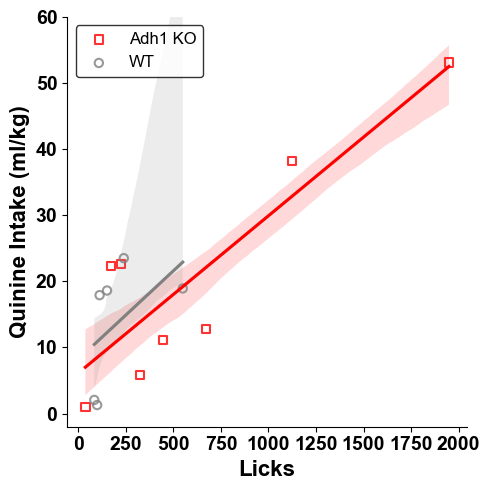

In [66]:
data = quinine.pivot_table(values=['Lick'],
                                 index=['ID','Duration','Genotype','Intake','Sex'],
                                 aggfunc='sum')

data.reset_index(inplace=True)

data = data.loc[data['Genotype'].isin(['WT', 'Adh1 KO'])]

data['Genotype'] = data['Genotype'].astype('category')
data['Sex'] = data['Sex'].astype('category')
data['ID'] = data['ID'].astype('category')
data['Duration'] = data['Duration'].astype('category')

data.sort_values(by='Genotype', ascending=True)

sns.lmplot(data = data, x = 'Lick', y = 'Intake', hue = 'Genotype', ci=68, palette=['#FF0000','#808080'], markers=["s","o"], legend=False, scatter_kws={'facecolors':'none', 'linewidths':1.5})

plt.yticks(fontweight='bold', size = 14)
plt.ylabel("Quinine Intake (ml/kg)", size = 16, fontweight='bold')

plt.xticks(fontweight='bold', size = 14)
plt.xlabel("Licks", size = 16, fontweight='bold')

plt.legend(loc = 'upper left', fontsize = 12, edgecolor='black')

plt.ylim(-2,60)

plt.tight_layout()
plt.savefig('raw_figs/quinine)licks.pdf')


# Fit a mixed effects model
model = smf.mixedlm('Intake ~ Lick * Genotype', data, groups=data['ID']).fit()

# Print the summary of the model
print(model.summary())

# Retrieve p-values
p_values = model.pvalues

# Print significant p-values (e.g., p < 0.05)
significant_p_values = p_values[p_values < 0.05]
print(significant_p_values)

In [67]:
hypothesis = 'Lick = 0'

# Perform the F-test
f_test_result = model.f_test(hypothesis)

# Print the F-test result
print(f_test_result)

<F test: F=41.22164013805272, p=7.630639927959585e-05, df_denom=10, df_num=1>


                  Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       Intake  
No. Observations:        14            Method:                   REML    
No. Groups:              7             Scale:                    22.3479 
Min. group size:         2             Log-Likelihood:           -44.8895
Max. group size:         2             Converged:                Yes     
Mean group size:         2.0                                             
-------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-------------------------------------------------------------------------
Intercept                      5.602    8.302  0.675 0.500 -10.670 21.875
Genotype[T.WT]                 8.541   10.611  0.805 0.421 -12.256 29.338
Lick_Duration                  0.469    0.192  2.437 0.015   0.092  0.846
Lick_Duration:Genotype[T.WT]  -0.483    0.204 -2.365 0.0

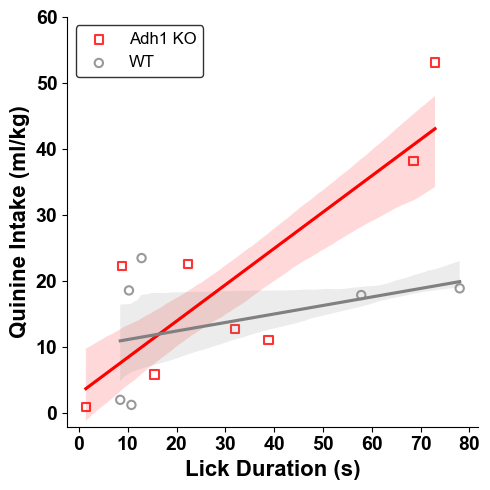

In [68]:
data = quinine.pivot_table(values=['Lick_Duration'],
                                 index=['ID','Duration','Genotype','Intake','Sex'],
                                 aggfunc='sum')

data.reset_index(inplace=True)

data = data.loc[data['Genotype'].isin(['WT', 'Adh1 KO'])]

data['Genotype'] = data['Genotype'].astype('category')
data['Sex'] = data['Sex'].astype('category')
data['ID'] = data['ID'].astype('category')
data['Duration'] = data['Duration'].astype('category')

data['Lick_Duration'] = data['Lick_Duration']/1000

data.sort_values(by='Genotype', ascending=True)

sns.lmplot(data = data, x = 'Lick_Duration', y = 'Intake', hue = 'Genotype', ci=68, palette=['#FF0000','#808080'], markers=["s","o"], legend=False, scatter_kws={'facecolors':'none', 'linewidths':1.5})

plt.yticks(fontweight='bold', size = 14)
plt.ylabel("Quinine Intake (ml/kg)", size = 16, fontweight='bold')

plt.xticks(fontweight='bold', size = 14)
plt.xlabel("Lick Duration (s)", size = 16, fontweight='bold')

plt.legend(loc = 'upper left', fontsize = 12, edgecolor='black')

plt.ylim(-2,60)

plt.tight_layout()
plt.savefig('raw_figs/quinine_lickduration.pdf')


# Fit a mixed effects model
model = smf.mixedlm('Intake ~ Lick_Duration * Genotype', data, groups=data['ID']).fit()

# Print the summary of the model
print(model.summary())

# Retrieve p-values
p_values = model.pvalues

# Print significant p-values (e.g., p < 0.05)
significant_p_values = p_values[p_values < 0.05]
print(significant_p_values)

In [70]:
hypothesis = 'Lick_Duration:Genotype[T.WT] = 0'

# Perform the F-test
f_test_result = model.f_test(hypothesis)

# Print the F-test result
print(f_test_result)

<F test: F=5.592494820517328, p=0.039624272349185974, df_denom=10, df_num=1>


                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Intake  
No. Observations:      14           Method:                  REML    
No. Groups:            7            Scale:                   30.8607 
Min. group size:       2            Log-Likelihood:          -43.7174
Max. group size:       2            Converged:               Yes     
Mean group size:       2.0                                           
---------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------
Intercept                  9.966    7.640  1.304 0.192  -5.008 24.940
Genotype[T.WT]             0.261   10.461  0.025 0.980 -20.243 20.764
BoutNumber                 0.665    0.340  1.957 0.050  -0.001  1.331
BoutNumber:Genotype[T.WT] -0.343    0.508 -0.676 0.499  -1.338  0.652
Group Var                 94.152   2

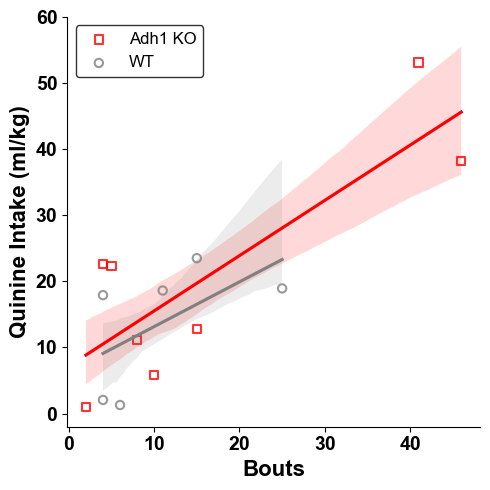

In [71]:
data = quinine.pivot_table(values=['BoutNumber'],
                                 index=['ID','Duration','Genotype','Intake','Sex','Session'],
                                 aggfunc='max')

data.reset_index(inplace=True)

data = data.loc[data['Genotype'].isin(['WT', 'Adh1 KO'])]

data['Genotype'] = data['Genotype'].astype('category')
data['Sex'] = data['Sex'].astype('category')
data['ID'] = data['ID'].astype('category')
data['Duration'] = data['Duration'].astype('category')

data.sort_values(by='Genotype', ascending=True)

sns.lmplot(data = data, x = 'BoutNumber', y = 'Intake', hue = 'Genotype', ci=68, palette=['#FF0000','#808080'], markers=["s","o"], legend=False, scatter_kws={'facecolors':'none', 'linewidths':1.5})

plt.yticks(fontweight='bold', size = 14)
plt.ylabel("Quinine Intake (ml/kg)", size = 16, fontweight='bold')

plt.xticks(fontweight='bold', size = 14)
plt.xlabel("Bouts", size = 16, fontweight='bold')

plt.legend(loc = 'upper left', fontsize = 12, edgecolor='black')

plt.ylim(-2,60)

plt.tight_layout()
plt.savefig('raw_figs/quinine_bouts.pdf')

# Fit a mixed effects model
model = smf.mixedlm('Intake ~ BoutNumber * Genotype', data, groups=data['ID']).fit()

# Print the summary of the model
print(model.summary())

# Retrieve p-values
p_values = model.pvalues

# Print significant p-values (e.g., p < 0.05)
significant_p_values = p_values[p_values < 0.05]
print(significant_p_values)

In [72]:
hypothesis = 'BoutNumber = 0'

# Perform the F-test
f_test_result = model.f_test(hypothesis)

# Print the F-test result
print(f_test_result)

<F test: F=3.8305487880711717, p=0.07880434112559152, df_denom=10, df_num=1>


                 W      pval  normal
Genotype                            
Adh1 KO   0.847575  0.654563    True
WT        0.850564  0.653585    True


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.979877,11.207783,two-sided,0.347825,"[-23.15, 8.87]",0.487032,0.612,0.132158


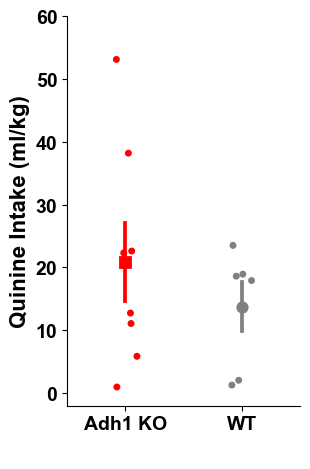

In [57]:
data = quinine.pivot_table(values=['Lick'],
                                 index=['ID','Duration','Genotype','Intake','Sex','Session'],
                                 aggfunc='sum')

data.reset_index(inplace=True)

data = data.loc[data['Genotype'].isin(['WT', 'Adh1 KO'])]

data.sort_values(by='Genotype', ascending=True)

plt.figure(figsize=(3.2, 4.8))  # Adjusted half witdth from default here

sns.pointplot(data = data, x = 'Genotype', hue = 'Genotype', y = 'Intake', linestyle ='none', errorbar='se', palette=['#FF0000','#808080'], markers=["s","o"], legend=False)
sns.stripplot(data = data, x = 'Genotype', hue = 'Genotype', y = 'Intake', palette=['#FF0000','#808080'], legend=False)
sns.despine()

plt.yticks(fontweight='bold', size = 14)
plt.ylabel("Quinine Intake (ml/kg)", size = 16, fontweight='bold')

plt.xticks(fontweight='bold', size = 14)
plt.xlabel(" ", size = 16, fontweight='bold')

plt.ylim(-2,60)

plt.tight_layout()
plt.savefig('raw_figs/quinine_intake.pdf')

print(pg.normality(data = data, dv = 'Intake', group='Genotype',  method="jarque_bera"))

pg.ttest(data.loc[data['Genotype'] == 'WT', "Intake"], data.loc[data['Genotype'] == 'Adh1 KO', "Intake"])
